In [1]:
# 1. 과거 주가 정보를 수집하는 방법
# 2. 시계열 예측 작업을 위한 데이터셋 형식을 구성하는 방법
# 3. 회귀 모델을 사용해 미래 주가를 예측하는 방법
# 4. 장단기 메모리(Long short-term memory, LSTM) 기초
# 5. LSTM으로 예측 성능을 높이는 방법
# 6. 텐서보드(Tensorboard)에 성능을 시각화하는 방법

In [3]:
import numpy as np

### 입력 데이터셋 - 코사인과 주가

In [3]:
# 시계열 데이터로 두 개의 일차원 신호를 사용

In [4]:
# 1. 균일한 잡음이 추가된 코사인파
# 점의 개수, 신호 주기, 균일한 잡음 생성기의 절대 강도가 매개변수로 주어졌을 때
# 코사인 신호를 생성하는 함수

def fetch_cosine_values(seq_len, frequency = 0.01, noise = 0.1) :
    # random seed를 설정해 실험을 복제할 수 있게 한다
    np.random.seed(101)
    x = np.arange(0.0, seq_len, 1.0)
    return np.cos(2 * np.pi * frequency * x) + np.random.uniform(low=-noise, high=noise, size=seq_len)

In [5]:
# 10개의 점, 0.1 크기의 잡음이 추가된 코사인의 전체 진동(따라서 주기가 0.1)을 한 번 출력
print(fetch_cosine_values(10, frequency=0.1))

[ 1.00327973  0.82315051  0.21471184 -0.37471266 -0.7719616  -0.93322063
 -0.84762375 -0.23029438  0.35332577  0.74700479]


In [6]:
# print(np.arange(0.0, 10, 1.0))
# x = np.arange(0.0, 10, 1.0)

In [7]:
# print(2 * np.pi * 0.1 * x)

In [8]:
# # np.pi : 3.141592653589793
# np.cos(2 * np.pi * 0.1 * x)

In [9]:
# np.random.seed(101)
# np.cos(2 * np.pi * 0.1 * x) + np.random.uniform(low=-0.1, high=0.1, size=10)

In [10]:
# 2. 실제 금융권
# 파이썬 라이브러리 : quandl

In [11]:
# $ curl "https://www.quandl.com/api/v3/datasets/WIKI/FB/data.csv"

In [12]:
s1 = "Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume"
s2 = "2018-03-27,156.31,162.85,150.75,152.19,76787884.0,0.0,1.0,156.31,162.85,150.75,152.19,76787884.0"

# print(s1.split(','))
# print(s2.split(','))

dic = {}
for i, j in zip(s1.split(','), s2.split(',')) :
    dic[i] = j
print(dic)

{'Date': '2018-03-27', 'Open': '156.31', 'High': '162.85', 'Low': '150.75', 'Close': '152.19', 'Volume': '76787884.0', 'Ex-Dividend': '0.0', 'Split Ratio': '1.0', 'Adj. Open': '156.31', 'Adj. High': '162.85', 'Adj. Low': '150.75', 'Adj. Close': '152.19', 'Adj. Volume': '76787884.0'}


In [13]:
# .csv
# 날짜, 시가, 고가, 저가, 종가, 조정가, 몇 가지 거래량, *조정 마감가*

In [14]:
# 파이썬 API를 사용해 조정가를 추출하는 파이썬 함수
# https://docs.quandl.com/v1.0/docs

In [15]:
import os
import pickle

In [16]:
# $ pip install quandl
import quandl

In [17]:
# datetime.date를 API에서 필요로 하는 적합한 문자열 형식으로 변환하는 헬퍼 함수
def date_obj_to_str(date_obj) :
    return date_obj.strftime('%Y-%m-%d')

In [18]:
# pickle
# dump

In [19]:
def save_pickle(something, path) :
    if not os.path.exists(os.path.dirname(path)) :
        os.makedirs(os.path.dirname(path))
    with open(path, 'wb') as fh :
        pickle.dump(something, fh, pickle.DEFAULT_PROTOCOL)

In [20]:
# def load_pickle(path) :
#     with open(path, 'rb') as fh :
#        return pickle.load(fh)

def load_pickle(path) :
    with open(path, 'rb') as fh :
        return pickle.load(fh)

In [21]:
quandl.ApiConfig.api_key = "b8siLwjzBZf5VMF28m9L"

In [22]:
# 해당 종목 기호에 대한 과거 데이터를 가져오기 위해 
# 호출 결과를 캐시에 저장하고 가져올 데이터의 시작과 끝의 타임스탬프를 지정할 수 있어야 한다.

# 일차원 배열로 요청한 종목 기호에 대한 주가를 포함하고 있으며,
# from_date에서 to_date로 정렬되어 있다

# 캐싱은 함수 내에서 이뤄지며,
# 이는 데이터가 캐시에서 발견되지 않으면 quandle API가 호출됨을 뜻한다
def fetch_stock_price(symbol, from_date, to_date, cache_path = './tmp/prices/') :
    assert(from_date <= to_date)
    filename = "{}_{}_{}.pk".format(symbol, str(from_date), str(to_date))
    price_filepath = os.path.join(cache_path, filename)
    try :
        prices = load_pickle(price_filepath)
        print("loaded from", price_filepath)
    except IOError :
        historic = quandl.get("WIKI/" + symbol, 
                              start_date = date_obj_to_str(from_date), 
                              end_date = date_obj_to_str(to_date))
        prices = historic["Adj. Close"].tolist()
        save_pickle(prices, price_filepath)
        print("saved into", price_filepath)
    return prices

In [23]:
# import os
# import pickle
# import quandl
# import numpy as np


# def date_obj_to_str(date_obj):
#     return date_obj.strftime('%Y-%m-%d')


# def save_pickle(something, path):
#     if not os.path.exists(os.path.dirname(path)):
#         os.makedirs(os.path.dirname(path))
#     with open(path, 'wb') as fh:
#         pickle.dump(something, fh, pickle.DEFAULT_PROTOCOL)


# def load_pickle(path):
#     with open(path, 'rb') as fh:
#         return pickle.load(fh)


# def fetch_stock_price(symbol,
#                       from_date,
#                       to_date,
#                       cache_path="./tmp/prices/"):
#     assert(from_date <= to_date)

#     filename = "{}_{}_{}.pk".format(symbol, str(from_date), str(to_date))
#     price_filepath = os.path.join(cache_path, filename)

#     try:
#         prices = load_pickle(price_filepath)
#         print("loaded from", price_filepath)

#     except IOError:
#         historic = quandl.get("WIKI/" + symbol,
#                               start_date=date_obj_to_str(from_date),
#                               end_date=date_obj_to_str(to_date))

#         prices = historic["Adj. Close"].tolist()
#         save_pickle(prices, price_filepath)
#         print("saved into", price_filepath)

#     return prices

In [24]:
import datetime

In [25]:
# 2017.01 구글 주가(종목 기호 : GOOG) 조정가 출력
# print(fetch_stock_price("GOOG", datetime.date(2017, 1, 1), datetime.date(2017, 1, 31)))

### 데이터셋 포맷 구성

In [26]:
def format_dataset(values, temporal_features) :
    # feat_splits = [ values[i:i+temporal_features] for i in range(len(values) - temporal_features) ]
    feat_splits = []
    for i in range(len(values) - temporal_features) :
        feat_splits.append(values[i:i+temporal_features])
    
    # 모든 관측값은 레이블과 함께 세로로 연결
    feats = np.vstack(feat_splits)
    labels = np.array(values[temporal_features :])
    
    # 정해진 개수의 열을 갖는 관측값과 레이블 벡터
    return feats, labels

In [6]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn

from tools import fetch_cosine_values, fetch_stock_price, format_dataset
np.set_printoptions(precision=2)

# Print 2 oscillations (20 points, with a frequency of 0.1, i.e. a period of 10)
# 주기 10, 20개의 점을 갖는 코사인 시계열
cos_values = fetch_cosine_values(20, frequency = 0.1)
seaborn.tsplot(cos_values)
plt.xlabel("Days since start of the experiment")
plt.ylabel("Value of the cosine function")
plt.title("Cosine time series over time")
plt.show()

ModuleNotFoundError: No module named 'tools'

In [28]:
print(cos_values)

[ 1.    0.82  0.21 -0.37 -0.77 -0.93 -0.85 -0.23  0.35  0.75  1.01  0.78
  0.25 -0.25 -0.72 -1.05 -0.89 -0.29  0.35  0.76]


In [29]:
print(cos_values.shape)

(20,)


In [30]:
# features_size = 5

In [31]:
# features_splits = []
# for i in range(len(cos_values) - features_size) :
#     # print(cos_values[i:i+features_size])
#     features_splits.append(cos_values[i:i+features_size])

In [32]:
# features_splits

In [33]:
# feats = np.vstack(features_splits)

In [34]:
# feats

In [35]:
# 위 시계열 데이터를
# 머신러닝 알고리즘에서 받아들일 수 있는 형식으로 바꿔서
# 5개의 열을 갖는 관측행렬을 만든다

features_size = 5
minibatch_cos_X , minibatch_cos_y = format_dataset(cos_values, features_size)
print('minibatch_cos_X.shape', minibatch_cos_X.shape)
print('minibatch_cos_y.shape', minibatch_cos_y.shape)

minibatch_cos_X.shape (15, 5)
minibatch_cos_y.shape (15,)


In [36]:
# 15x5 크기의 관측값 행렬
minibatch_cos_X

array([[ 1.  ,  0.82,  0.21, -0.37, -0.77],
       [ 0.82,  0.21, -0.37, -0.77, -0.93],
       [ 0.21, -0.37, -0.77, -0.93, -0.85],
       [-0.37, -0.77, -0.93, -0.85, -0.23],
       [-0.77, -0.93, -0.85, -0.23,  0.35],
       [-0.93, -0.85, -0.23,  0.35,  0.75],
       [-0.85, -0.23,  0.35,  0.75,  1.01],
       [-0.23,  0.35,  0.75,  1.01,  0.78],
       [ 0.35,  0.75,  1.01,  0.78,  0.25],
       [ 0.75,  1.01,  0.78,  0.25, -0.25],
       [ 1.01,  0.78,  0.25, -0.25, -0.72],
       [ 0.78,  0.25, -0.25, -0.72, -1.05],
       [ 0.25, -0.25, -0.72, -1.05, -0.89],
       [-0.25, -0.72, -1.05, -0.89, -0.29],
       [-0.72, -1.05, -0.89, -0.29,  0.35]])

In [37]:
# 15개의 요소를 갖는 레이블 벡터
minibatch_cos_y

array([-0.93, -0.85, -0.23,  0.35,  0.75,  1.01,  0.78,  0.25, -0.25,
       -0.72, -1.05, -0.89, -0.29,  0.35,  0.76])

Observation 0 : X=[ 1.    0.82  0.21 -0.37 -0.77] y=-0.9332206274727847
Observation 1 : X=[ 0.82  0.21 -0.37 -0.77 -0.93] y=-0.8476237504404999
Observation 2 : X=[ 0.21 -0.37 -0.77 -0.93 -0.85] y=-0.23029437843826808
Observation 3 : X=[-0.37 -0.77 -0.93 -0.85 -0.23] y=0.35332576672860816
Observation 4 : X=[-0.77 -0.93 -0.85 -0.23  0.35] y=0.7470047852159067


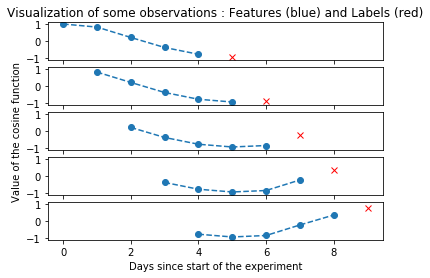

In [38]:
# 시각화
samples_to_plot = 5
f, axarr = plt.subplots(samples_to_plot, sharex = True)
for i in range(samples_to_plot) :
    feats = minibatch_cos_X[i, :]
    label = minibatch_cos_y[i]
    print("Observation {} : X={} y={}".format(i, feats, label))
    
    # plt.subplot(samples_to_plot, 1, i+1)
    axarr[i].plot(range(i, features_size+i), feats, '--o')
    axarr[i].plot([features_size+i], label, 'rx')
    axarr[i].set_ylim([-1.1, 1.1])

plt.xlabel("Days since start of the experiment")
axarr[2].set_ylabel("Value of the cosine function")
axarr[0].set_title("Visualization of some observations : Features (blue) and Labels (red)")
plt.show()

In [39]:
# os.path.join("./tmp/prices/", "MSFT_2015-01-01_2016-12-31.pk")
# './tmp/prices/MSFT_2015-01-01_2016-12-31.pk'

loaded from ./tmp/prices/MSFT_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/KO_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/AAL_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/MMM_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/AXP_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/GE_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/GM_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/JPM_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/UPS_2015-01-01_2016-12-31.pk


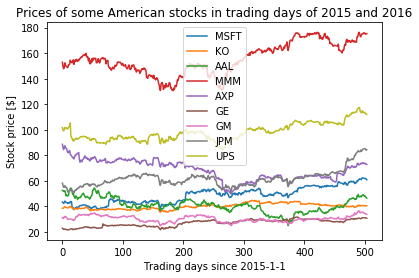

In [40]:
symbols = ["MSFT", "KO", "AAL", "MMM", "AXP", "GE", "GM", "JPM", "UPS"]
ax = plt.subplot(1, 1, 1)
for sym in symbols :
    prices = fetch_stock_price(sym, datetime.date(2015, 1, 1), datetime.date(2016, 12, 31))
    ax.plot(range(len(prices)), prices, label = sym)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.xlabel("Trading days since 2015-1-1")
plt.ylabel("Stock price [$]")
plt.title("Prices of some American stocks in trading days of 2015 and 2016")
plt.show()

In [41]:
# handles, labels = ax.get_legend_handles_labels()
# handles, labels

In [42]:
# historic = quandl.get("WIKI/" + "MSFT", start_date=date_obj_to_str(datetime.date(2015, 1, 1)), end_date=date_obj_to_str(datetime.date(2016, 12, 31)))

In [43]:
# historic["Adj. Close"]

In [44]:
# historic["Adj. Close"].tolist()

### 회귀 모델을 이용한 미래 주가 예측

In [45]:
# 관측 행렬과 실제 값 레이블이 주어지면 
# 처음에는 이 문제를 회귀 문제로 풀고 싶기 마련이다.
# 이 경우 회귀는 매우 간단
# 수치 벡터에서 수치 값을 예측하는 것
# => 이상적인 방법이 아니다

# 문제를 회귀 문제로 다루게 되면
# 알고리즘은 각 특징이 독립적이라고 간주해야 한다
# 그러나 이 예제에서 각 특징은
# 동일한 시계열의 슬라이딩 윈도우이므로 서로 상관되어 있다

# 우선 '각 특징이 독립적'이라는 단순한 가정에서 시작

In [46]:
# 행렬을 일차원 배열로 변환하는 헬퍼 함수
def matrix_to_array(m) :
    return np.asarray(m).reshape(-1)

In [47]:
# array1 = np.array([[1, 2, 3, 4, 5], [2, 3, 4, 5, 6]])
# array1

In [48]:
# print(array1)

In [49]:
# np.asarray(array1)

In [50]:
# np.asarray(array1).reshape(-1)

In [51]:
# matrix_to_array(array1)

In [52]:
# 평가 함수

import numpy as np
from matplotlib import pylab as plt
from tools import matrix_to_array

def evaluate_ts(features, y_true, y_pred) :
    # 예측에 대한 지표
    print("Evaluation of the predictions :")
    # 1. 평균 제곱 오차(MSE)
    print("MSE : ", np.mean(np.square(y_true - y_pred)))
    # 2. 평균 절대 오차(MAE)
    print("MAE : ", np.mean(np.abs(y_true - y_pred)))
    
    # 결과 비교를 위해
    # 어떤 모델도 사용하지 않고
    # 현재 날짜의 값을 다음 날 값으로 그대로 가져가 예측할 경우의 지표
    # (주식 시장에서 내일 주가가 오늘 주가와 같을 것으로 예측한다는 뜻)
    print("Benchmark : if prediction == last feature")
    print("MSE : ", np.mean(np.square(features[:, -1] - y_true)))
    print("MAE : ", np.mean(np.abs(features[:, -1] - y_true)))
    
    # 실제값
    plt.plot(matrix_to_array(y_true), 'b')
    # 예측값
    plt.plot(matrix_to_array(y_pred), 'r--')
    plt.xlabel("Days")
    plt.ylabel("Predicted and true values")
    plt.title("Predicted (Red) VS Real (Blue)")
    plt.show()
    
    error = np.abs(matrix_to_array(y_pred) - matrix_to_array(y_true))
    plt.plot(error, 'r')
    fit = np.polyfit(range(len(error)), error, deg = 1)
    plt.plot(fit[0] * range(len(error)) + fit[1], '--')
    plt.xlabel("Days")
    plt.ylabel("Prediction error L1 norm")
    plt.title("Prediction error (absolute) and trendline")
    plt.show()

In [53]:
# 회귀 알고리즘
# 관측 행렬을 가중치 배열과 곱해서 편향값을 더하는 방식
def regression_ANN(x, weights, biases) :
    return tf.add(biases, tf.matmul(x, weights))

Training iteration 0 MSE 4.394244
Training iteration 1 MSE 1.3426099
Training iteration 2 MSE 1.2859138
Training iteration 3 MSE 1.842526
Training iteration 4 MSE 1.6616912
Training iteration 5 MSE 0.99316734
Training iteration 6 MSE 0.39235488
Training iteration 7 MSE 0.18088077
Training iteration 8 MSE 0.32896882
Training iteration 9 MSE 0.5551951
Training iteration 10 MSE 0.6037027
Training iteration 11 MSE 0.44349512
Training iteration 12 MSE 0.22051524
Training iteration 13 MSE 0.100527726
Training iteration 14 MSE 0.14700674
Training iteration 15 MSE 0.29074195
Training iteration 16 MSE 0.40164787
Training iteration 17 MSE 0.3993418
Training iteration 18 MSE 0.3027106
Training iteration 19 MSE 0.19331583
Training iteration 20 MSE 0.14344183
Training iteration 21 MSE 0.16518219
Training iteration 22 MSE 0.21137288
Training iteration 23 MSE 0.22246559
Training iteration 24 MSE 0.17670807
Training iteration 25 MSE 0.10183797
Training iteration 26 MSE 0.04602803
Training iteration 27

Training iteration 231 MSE 0.014957516
Training iteration 232 MSE 0.014895836
Training iteration 233 MSE 0.014834364
Training iteration 234 MSE 0.014773095
Training iteration 235 MSE 0.014712027
Training iteration 236 MSE 0.014651164
Training iteration 237 MSE 0.0145905055
Training iteration 238 MSE 0.014530053
Training iteration 239 MSE 0.014469808
Training iteration 240 MSE 0.014409771
Training iteration 241 MSE 0.0143499365
Training iteration 242 MSE 0.014290316
Training iteration 243 MSE 0.014230902
Training iteration 244 MSE 0.014171697
Training iteration 245 MSE 0.014112702
Training iteration 246 MSE 0.0140539175
Training iteration 247 MSE 0.013995345
Training iteration 248 MSE 0.013936979
Training iteration 249 MSE 0.013878829
Training iteration 250 MSE 0.013820887
Training iteration 251 MSE 0.013763161
Training iteration 252 MSE 0.013705646
Training iteration 253 MSE 0.013648341
Training iteration 254 MSE 0.013591254
Training iteration 255 MSE 0.013534379
Training iteration 256

Training iteration 523 MSE 0.0051589548
Training iteration 524 MSE 0.0051467703
Training iteration 525 MSE 0.005134673
Training iteration 526 MSE 0.0051226616
Training iteration 527 MSE 0.005110737
Training iteration 528 MSE 0.005098899
Training iteration 529 MSE 0.005087145
Training iteration 530 MSE 0.005075476
Training iteration 531 MSE 0.0050638914
Training iteration 532 MSE 0.0050523914
Training iteration 533 MSE 0.0050409725
Training iteration 534 MSE 0.0050296388
Training iteration 535 MSE 0.0050183856
Training iteration 536 MSE 0.005007214
Training iteration 537 MSE 0.0049961247
Training iteration 538 MSE 0.004985114
Training iteration 539 MSE 0.0049741855
Training iteration 540 MSE 0.0049633365
Training iteration 541 MSE 0.004952566
Training iteration 542 MSE 0.0049418737
Training iteration 543 MSE 0.00493126
Training iteration 544 MSE 0.0049207252
Training iteration 545 MSE 0.0049102646
Training iteration 546 MSE 0.0048998836
Training iteration 547 MSE 0.0048895767
Training i

Training iteration 791 MSE 0.003769318
Training iteration 792 MSE 0.0037678992
Training iteration 793 MSE 0.003766493
Training iteration 794 MSE 0.003765098
Training iteration 795 MSE 0.0037637153
Training iteration 796 MSE 0.003762346
Training iteration 797 MSE 0.0037609874
Training iteration 798 MSE 0.0037596403
Training iteration 799 MSE 0.003758305
Training iteration 800 MSE 0.003756981
Training iteration 801 MSE 0.0037556689
Training iteration 802 MSE 0.0037543683
Training iteration 803 MSE 0.0037530789
Training iteration 804 MSE 0.0037518
Training iteration 805 MSE 0.0037505336
Training iteration 806 MSE 0.003749277
Training iteration 807 MSE 0.003748032
Training iteration 808 MSE 0.0037467976
Training iteration 809 MSE 0.0037455738
Training iteration 810 MSE 0.003744361
Training iteration 811 MSE 0.0037431584
Training iteration 812 MSE 0.0037419663
Training iteration 813 MSE 0.0037407847
Training iteration 814 MSE 0.003739613
Training iteration 815 MSE 0.003738452
Training itera

Test dataset :  0.004545134
Evaluation of the predictions:
MSE: 0.0045451345
mae: 0.056850147
Benchmark: if prediction == last feature
MSE: 0.96430165
mae: 0.79347515


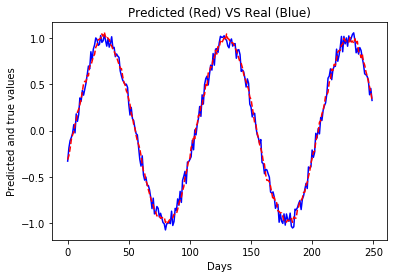

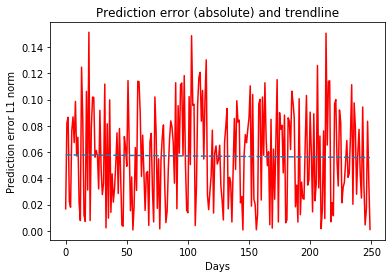

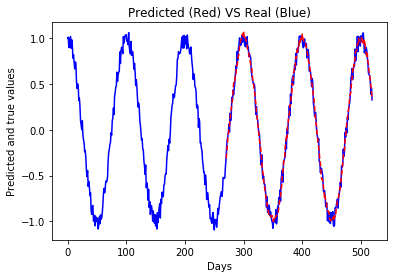

In [55]:
# 모델링
# regression_cosine

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from evaluate_ts import evaluate_ts
from tensorflow.contrib import rnn
from tools import fetch_cosine_values, format_dataset

tf.reset_default_graph()
tf.set_random_seed(101)

# Settings for the dataset creation
# 특징 크기로 대략 한 달의 영업일수에 해당하는 20을 사용
# => 과거 코사인의 값이 20개가 주어졌을 때 다음 날의 값을 예측하는 문제
feat_dimension = 20
train_size = 250
test_size = 250

# Settings for tensorflow
# 1. 학습 속도
# 2. 사용할 최적화 알고리즘
# 3. 세대 수(훈련시킬 때 훈련 데이터셋이 학습 모델에 얼마나 많이 들어가는지)
learning_rate = 0.1
optimizer = tf.train.AdamOptimizer
n_epochs = 1000

# 데이터셋
cos_values = fetch_cosine_values(train_size + test_size + feat_dimension)
minibatch_cos_X, minibatch_cos_y = format_dataset(cos_values, feat_dimension)
train_X = minibatch_cos_X[:train_size, :].astype(np.float32)
train_y = minibatch_cos_y[:train_size].reshape((-1, 1)).astype(np.float32)
test_X = minibatch_cos_X[train_size:, :].astype(np.float32)
test_y = minibatch_cos_y[train_size:].reshape((-1, 1)).astype(np.float32)

# 플레이스홀더 정의
X_tf = tf.placeholder("float", shape = (None, feat_dimension), name = "X")
y_tf = tf.placeholder("float", shape = (None, 1), name = "y")

# 훈련 가능한 매개변수(가중치, 편향값) 초기화
# truncated_normal : 절단 정규 분포
weights = tf.Variable(tf.truncated_normal([feat_dimension, 1], mean = 0.0, stddev = 1.0), name = 'weights')
biases = tf.Variable(tf.zeros([1, 1]), name = 'bias')

y_pred = regression_ANN(X_tf, weights, biases)
cost = tf.reduce_mean(tf.square(y_tf - y_pred))
train_op = optimizer(learning_rate).minimize(cost)

with tf.Session() as sess :
    # 변수 초기화
    sess.run(tf.global_variables_initializer())
    
    # 한 세대마다 전체 훈련 데이터셋이 텐서플로 그래프에 공급된다
    for i in range(n_epochs) :
        train_cost, _ = sess.run([cost, train_op], feed_dict = {X_tf : train_X, y_tf : train_y})
        print("Training iteration", i, "MSE", train_cost)
        
    # 훈련시킨 다음
    # 테스트 데이터셋에 대한 성능 확인
    test_cost, y_pr = sess.run([cost, y_pred], feed_dict= {X_tf : test_X, y_tf : test_y})
    print("Test dataset : ", test_cost)
    
    # 결과 평가
    evaluate_ts(test_X, test_y, y_pr)
    
    # 예측값이 어떻게 보이는지 확인
    plt.plot(range(len(cos_values)), cos_values, 'b')
    plt.plot(range(len(cos_values)-test_size, len(cos_values)), y_pr, 'r--')
    plt.xlabel("Days")
    plt.ylabel("Predicted and true values")
    plt.title("Predicted (Red) VS Real (Blue)")
    plt.show()

loaded from ./tmp/prices/MSFT_2015-01-01_2016-12-31.pk
Training iteration 0 MSE 18262.947
Training iteration 1 MSE 8229.953
Training iteration 2 MSE 2267.759
Training iteration 3 MSE 68.44234
Training iteration 4 MSE 706.69147
Training iteration 5 MSE 2604.0486
Training iteration 6 MSE 4183.6143
Training iteration 7 MSE 4658.7095
Training iteration 8 MSE 4068.4358
Training iteration 9 MSE 2859.0068
Training iteration 10 MSE 1544.382
Training iteration 11 MSE 532.78
Training iteration 12 MSE 48.31244
Training iteration 13 MSE 105.998665
Training iteration 14 MSE 538.39325
Training iteration 15 MSE 1078.2084
Training iteration 16 MSE 1472.474
Training iteration 17 MSE 1575.084
Training iteration 18 MSE 1377.6748
Training iteration 19 MSE 981.2049
Training iteration 20 MSE 537.48376
Training iteration 21 MSE 188.812
Training iteration 22 MSE 22.66185
Training iteration 23 MSE 50.31427
Training iteration 24 MSE 213.18597
Training iteration 25 MSE 413.47842
Training iteration 26 MSE 556.391

Training iteration 251 MSE 10.75258
Training iteration 252 MSE 10.745732
Training iteration 253 MSE 10.738877
Training iteration 254 MSE 10.732013
Training iteration 255 MSE 10.725152
Training iteration 256 MSE 10.718285
Training iteration 257 MSE 10.711412
Training iteration 258 MSE 10.704532
Training iteration 259 MSE 10.697652
Training iteration 260 MSE 10.690773
Training iteration 261 MSE 10.683894
Training iteration 262 MSE 10.676996
Training iteration 263 MSE 10.670107
Training iteration 264 MSE 10.663208
Training iteration 265 MSE 10.656306
Training iteration 266 MSE 10.649404
Training iteration 267 MSE 10.642502
Training iteration 268 MSE 10.635601
Training iteration 269 MSE 10.628677
Training iteration 270 MSE 10.621766
Training iteration 271 MSE 10.614849
Training iteration 272 MSE 10.607926
Training iteration 273 MSE 10.60101
Training iteration 274 MSE 10.594081
Training iteration 275 MSE 10.587159
Training iteration 276 MSE 10.580225
Training iteration 277 MSE 10.573295
Tra

Training iteration 533 MSE 8.829264
Training iteration 534 MSE 8.822855
Training iteration 535 MSE 8.81644
Training iteration 536 MSE 8.8100395
Training iteration 537 MSE 8.803634
Training iteration 538 MSE 8.797237
Training iteration 539 MSE 8.790851
Training iteration 540 MSE 8.784461
Training iteration 541 MSE 8.778086
Training iteration 542 MSE 8.771706
Training iteration 543 MSE 8.765336
Training iteration 544 MSE 8.758962
Training iteration 545 MSE 8.752603
Training iteration 546 MSE 8.746233
Training iteration 547 MSE 8.73988
Training iteration 548 MSE 8.733528
Training iteration 549 MSE 8.727184
Training iteration 550 MSE 8.720842
Training iteration 551 MSE 8.714503
Training iteration 552 MSE 8.708175
Training iteration 553 MSE 8.701835
Training iteration 554 MSE 8.695514
Training iteration 555 MSE 8.689195
Training iteration 556 MSE 8.682877
Training iteration 557 MSE 8.676571
Training iteration 558 MSE 8.670261
Training iteration 559 MSE 8.663959
Training iteration 560 MSE 8.

Training iteration 846 MSE 7.0489774
Training iteration 847 MSE 7.0440235
Training iteration 848 MSE 7.0390773
Training iteration 849 MSE 7.034129
Training iteration 850 MSE 7.0291996
Training iteration 851 MSE 7.0242596
Training iteration 852 MSE 7.0193305
Training iteration 853 MSE 7.0144095
Training iteration 854 MSE 7.0094953
Training iteration 855 MSE 7.0045733
Training iteration 856 MSE 6.9996657
Training iteration 857 MSE 6.9947596
Training iteration 858 MSE 6.9898577
Training iteration 859 MSE 6.984958
Training iteration 860 MSE 6.9800715
Training iteration 861 MSE 6.975179
Training iteration 862 MSE 6.9702954
Training iteration 863 MSE 6.965419
Training iteration 864 MSE 6.960544
Training iteration 865 MSE 6.955672
Training iteration 866 MSE 6.9508095
Training iteration 867 MSE 6.945948
Training iteration 868 MSE 6.9410934
Training iteration 869 MSE 6.936242
Training iteration 870 MSE 6.9314003
Training iteration 871 MSE 6.926554
Training iteration 872 MSE 6.921716
Training it

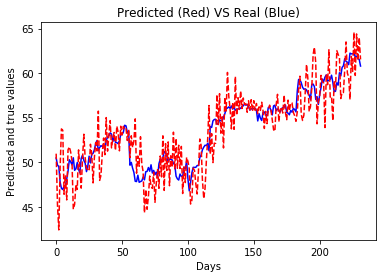

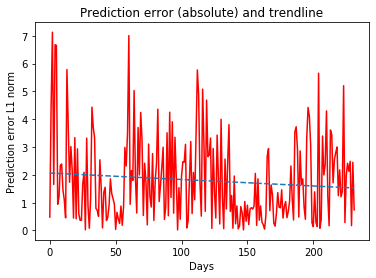

In [56]:
# 주가 예측

symbol = "MSFT"
feat_dimension = 20
train_size = 252
test_size = 252-feat_dimension

# 텐서플로 설정
learning_rate = 0.05
optimizer = tf.train.AdamOptimizer
n_epochs = 1000

# 주가를 가져와 훈련 데이터와 테스트 데이터를 분할
stock_values = fetch_stock_price(symbol, datetime.date(2015, 1, 1), datetime.date(2016, 12, 31))
minibatch_stock_X, minibatch_stock_y = format_dataset(stock_values, feat_dimension)
train_X = minibatch_stock_X[:train_size, :].astype(np.float32)
train_y = minibatch_stock_y[:train_size].reshape((-1, 1)).astype(np.float32)
test_X = minibatch_stock_X[train_size:, :].astype(np.float32)
test_y = minibatch_stock_y[train_size:].reshape((-1, 1)).astype(np.float32)

# 플레이스홀더 정의
X_tf = tf.placeholder("float", shape = (None, feat_dimension), name = "X")
y_tf = tf.placeholder("float", shape = (None, 1), name = "y")

# 훈련 가능한 매개변수(가중치, 편향값) 초기화
# truncated_normal : 절단 정규 분포
weights = tf.Variable(tf.truncated_normal([feat_dimension, 1], mean = 0.0, stddev = 1.0), name = 'weights')
biases = tf.Variable(tf.zeros([1, 1]), name = 'bias')

y_pred = regression_ANN(X_tf, weights, biases)
cost = tf.reduce_mean(tf.square(y_tf - y_pred))
train_op = optimizer(learning_rate).minimize(cost)

with tf.Session() as sess :
    # 변수 초기화
    sess.run(tf.global_variables_initializer())
    
    # 한 세대마다 전체 훈련 데이터셋이 텐서플로 그래프에 공급된다
    for i in range(n_epochs) :
        train_cost, _ = sess.run([cost, train_op], feed_dict = {X_tf : train_X, y_tf : train_y})
        print("Training iteration", i, "MSE", train_cost)
        
    # 훈련시킨 다음
    # 테스트 데이터셋에 대한 성능 확인
    test_cost, y_pr = sess.run([cost, y_pred], feed_dict= {X_tf : test_X, y_tf : test_y})
    print("Test dataset : ", test_cost)
    
    # 결과 평가
    evaluate_ts(test_X, test_y, y_pr)

loaded from ./tmp/prices/MSFT_2015-01-01_2016-12-31.pk
Training iteration 0 MSE 32777.03
Training iteration 1 MSE 69391.21
Training iteration 2 MSE 25420.252
Training iteration 3 MSE 1551.506
Training iteration 4 MSE 29872.783
Training iteration 5 MSE 28664.277
Training iteration 6 MSE 5732.374
Training iteration 7 MSE 1914.2205
Training iteration 8 MSE 16015.827
Training iteration 9 MSE 18850.287
Training iteration 10 MSE 7176.12
Training iteration 11 MSE 8.016051
Training iteration 12 MSE 5608.299
Training iteration 13 MSE 12028.292
Training iteration 14 MSE 8738.522
Training iteration 15 MSE 1569.8584
Training iteration 16 MSE 680.92365
Training iteration 17 MSE 5513.7104
Training iteration 18 MSE 7387.526
Training iteration 19 MSE 3593.4067
Training iteration 20 MSE 124.15861
Training iteration 21 MSE 1488.1619
Training iteration 22 MSE 4429.085
Training iteration 23 MSE 3946.6548
Training iteration 24 MSE 1021.1852
Training iteration 25 MSE 115.0614
Training iteration 26 MSE 1960.

Training iteration 265 MSE 4.23322
Training iteration 266 MSE 4.226704
Training iteration 267 MSE 4.2202177
Training iteration 268 MSE 4.2137628
Training iteration 269 MSE 4.207343
Training iteration 270 MSE 4.2009535
Training iteration 271 MSE 4.1946006
Training iteration 272 MSE 4.1882744
Training iteration 273 MSE 4.181981
Training iteration 274 MSE 4.1757183
Training iteration 275 MSE 4.1694846
Training iteration 276 MSE 4.163284
Training iteration 277 MSE 4.15711
Training iteration 278 MSE 4.150967
Training iteration 279 MSE 4.144854
Training iteration 280 MSE 4.138767
Training iteration 281 MSE 4.132714
Training iteration 282 MSE 4.126688
Training iteration 283 MSE 4.120689
Training iteration 284 MSE 4.11472
Training iteration 285 MSE 4.108777
Training iteration 286 MSE 4.1028566
Training iteration 287 MSE 4.0969706
Training iteration 288 MSE 4.091108
Training iteration 289 MSE 4.0852714
Training iteration 290 MSE 4.0794616
Training iteration 291 MSE 4.073681
Training iteration 2

Training iteration 557 MSE 3.0024903
Training iteration 558 MSE 2.9994488
Training iteration 559 MSE 2.9964123
Training iteration 560 MSE 2.9933817
Training iteration 561 MSE 2.9903567
Training iteration 562 MSE 2.987335
Training iteration 563 MSE 2.9843214
Training iteration 564 MSE 2.981311
Training iteration 565 MSE 2.9783077
Training iteration 566 MSE 2.9753077
Training iteration 567 MSE 2.9723141
Training iteration 568 MSE 2.9693255
Training iteration 569 MSE 2.9663405
Training iteration 570 MSE 2.9633605
Training iteration 571 MSE 2.9603899
Training iteration 572 MSE 2.9574194
Training iteration 573 MSE 2.954456
Training iteration 574 MSE 2.9514995
Training iteration 575 MSE 2.948545
Training iteration 576 MSE 2.945597
Training iteration 577 MSE 2.942655
Training iteration 578 MSE 2.9397142
Training iteration 579 MSE 2.9367816
Training iteration 580 MSE 2.9338553
Training iteration 581 MSE 2.9309344
Training iteration 582 MSE 2.9280138
Training iteration 583 MSE 2.9251
Training i

Training iteration 871 MSE 2.2610662
Training iteration 872 MSE 2.259259
Training iteration 873 MSE 2.2574515
Training iteration 874 MSE 2.2556472
Training iteration 875 MSE 2.253846
Training iteration 876 MSE 2.2520466
Training iteration 877 MSE 2.250249
Training iteration 878 MSE 2.248457
Training iteration 879 MSE 2.2466676
Training iteration 880 MSE 2.2448802
Training iteration 881 MSE 2.2430947
Training iteration 882 MSE 2.2413132
Training iteration 883 MSE 2.239532
Training iteration 884 MSE 2.2377563
Training iteration 885 MSE 2.2359817
Training iteration 886 MSE 2.2342098
Training iteration 887 MSE 2.2324383
Training iteration 888 MSE 2.2306745
Training iteration 889 MSE 2.2289104
Training iteration 890 MSE 2.2271485
Training iteration 891 MSE 2.2253904
Training iteration 892 MSE 2.2236338
Training iteration 893 MSE 2.2218812
Training iteration 894 MSE 2.2201307
Training iteration 895 MSE 2.2183812
Training iteration 896 MSE 2.216636
Training iteration 897 MSE 2.214894
Training

Training iteration 1177 MSE 1.8101279
Training iteration 1178 MSE 1.8089248
Training iteration 1179 MSE 1.8077221
Training iteration 1180 MSE 1.8065202
Training iteration 1181 MSE 1.8053211
Training iteration 1182 MSE 1.8041234
Training iteration 1183 MSE 1.8029257
Training iteration 1184 MSE 1.8017298
Training iteration 1185 MSE 1.8005372
Training iteration 1186 MSE 1.7993445
Training iteration 1187 MSE 1.7981528
Training iteration 1188 MSE 1.7969632
Training iteration 1189 MSE 1.7957735
Training iteration 1190 MSE 1.7945864
Training iteration 1191 MSE 1.7934004
Training iteration 1192 MSE 1.7922171
Training iteration 1193 MSE 1.7910326
Training iteration 1194 MSE 1.789852
Training iteration 1195 MSE 1.7886714
Training iteration 1196 MSE 1.7874925
Training iteration 1197 MSE 1.7863144
Training iteration 1198 MSE 1.7851388
Training iteration 1199 MSE 1.7839638
Training iteration 1200 MSE 1.78279
Training iteration 1201 MSE 1.7816162
Training iteration 1202 MSE 1.780446
Training iterati

Training iteration 1454 MSE 1.5576924
Training iteration 1455 MSE 1.5569327
Training iteration 1456 MSE 1.5561802
Training iteration 1457 MSE 1.5554291
Training iteration 1458 MSE 1.5546744
Training iteration 1459 MSE 1.5539169
Training iteration 1460 MSE 1.5531605
Training iteration 1461 MSE 1.5524032
Training iteration 1462 MSE 1.5516505
Training iteration 1463 MSE 1.5509
Training iteration 1464 MSE 1.5501496
Training iteration 1465 MSE 1.5493978
Training iteration 1466 MSE 1.548645
Training iteration 1467 MSE 1.5478929
Training iteration 1468 MSE 1.5471418
Training iteration 1469 MSE 1.5463923
Training iteration 1470 MSE 1.545643
Training iteration 1471 MSE 1.5448958
Training iteration 1472 MSE 1.5441476
Training iteration 1473 MSE 1.5433983
Training iteration 1474 MSE 1.5426502
Training iteration 1475 MSE 1.541903
Training iteration 1476 MSE 1.5411565
Training iteration 1477 MSE 1.5404111
Training iteration 1478 MSE 1.5396669
Training iteration 1479 MSE 1.5389212
Training iteration

Training iteration 1735 MSE 1.3827168
Training iteration 1736 MSE 1.3928127
Training iteration 1737 MSE 1.3930439
Training iteration 1738 MSE 1.3832809
Training iteration 1739 MSE 1.375201
Training iteration 1740 MSE 1.3763529
Training iteration 1741 MSE 1.382235
Training iteration 1742 MSE 1.38387
Training iteration 1743 MSE 1.3789511
Training iteration 1744 MSE 1.3731225
Training iteration 1745 MSE 1.372011
Training iteration 1746 MSE 1.374906
Training iteration 1747 MSE 1.3768107
Training iteration 1748 MSE 1.3748443
Training iteration 1749 MSE 1.3709888
Training iteration 1750 MSE 1.3689444
Training iteration 1751 MSE 1.3697449
Training iteration 1752 MSE 1.3711724
Training iteration 1753 MSE 1.3707904
Training iteration 1754 MSE 1.3685935
Training iteration 1755 MSE 1.3665248
Training iteration 1756 MSE 1.3660266
Training iteration 1757 MSE 1.3666303
Training iteration 1758 MSE 1.366828
Training iteration 1759 MSE 1.365836
Training iteration 1760 MSE 1.3642597
Training iteration 1

Training iteration 2022 MSE 5.124948
Training iteration 2023 MSE 12.622228
Training iteration 2024 MSE 10.3052845
Training iteration 2025 MSE 2.7725122
Training iteration 2026 MSE 2.1393142
Training iteration 2027 MSE 7.3283696
Training iteration 2028 MSE 8.335679
Training iteration 2029 MSE 3.738946
Training iteration 2030 MSE 1.2548432
Training iteration 2031 MSE 3.864531
Training iteration 2032 MSE 6.077886
Training iteration 2033 MSE 4.1206536
Training iteration 2034 MSE 1.4460475
Training iteration 2035 MSE 1.9869195
Training iteration 2036 MSE 4.00501
Training iteration 2037 MSE 3.8607445
Training iteration 2038 MSE 1.9436686
Training iteration 2039 MSE 1.2900555
Training iteration 2040 MSE 2.4569936
Training iteration 2041 MSE 3.1625402
Training iteration 2042 MSE 2.2754767
Training iteration 2043 MSE 1.2861961
Training iteration 2044 MSE 1.5646412
Training iteration 2045 MSE 2.342105
Training iteration 2046 MSE 2.2689445
Training iteration 2047 MSE 1.5221226
Training iteration 

Training iteration 2331 MSE 5648.139
Training iteration 2332 MSE 7398.615
Training iteration 2333 MSE 7219.3413
Training iteration 2334 MSE 4299.198
Training iteration 2335 MSE 871.75757
Training iteration 2336 MSE 150.39021
Training iteration 2337 MSE 2102.954
Training iteration 2338 MSE 3684.2168
Training iteration 2339 MSE 2690.9817
Training iteration 2340 MSE 548.6287
Training iteration 2341 MSE 141.89096
Training iteration 2342 MSE 1496.868
Training iteration 2343 MSE 2152.2795
Training iteration 2344 MSE 1083.0623
Training iteration 2345 MSE 35.016773
Training iteration 2346 MSE 451.7241
Training iteration 2347 MSE 1281.907
Training iteration 2348 MSE 1034.3843
Training iteration 2349 MSE 184.54417
Training iteration 2350 MSE 95.61758
Training iteration 2351 MSE 676.37024
Training iteration 2352 MSE 787.7101
Training iteration 2353 MSE 263.2563
Training iteration 2354 MSE 7.1194487
Training iteration 2355 MSE 326.17862
Training iteration 2356 MSE 538.35333
Training iteration 2357

Training iteration 2630 MSE 1.0418084
Training iteration 2631 MSE 1.0415378
Training iteration 2632 MSE 1.0412668
Training iteration 2633 MSE 1.0409968
Training iteration 2634 MSE 1.0407255
Training iteration 2635 MSE 1.0404553
Training iteration 2636 MSE 1.0401844
Training iteration 2637 MSE 1.0399141
Training iteration 2638 MSE 1.0396435
Training iteration 2639 MSE 1.0393738
Training iteration 2640 MSE 1.0391032
Training iteration 2641 MSE 1.0388331
Training iteration 2642 MSE 1.0385634
Training iteration 2643 MSE 1.038293
Training iteration 2644 MSE 1.0380234
Training iteration 2645 MSE 1.0377524
Training iteration 2646 MSE 1.0374836
Training iteration 2647 MSE 1.0372136
Training iteration 2648 MSE 1.0369436
Training iteration 2649 MSE 1.0366746
Training iteration 2650 MSE 1.0364046
Training iteration 2651 MSE 1.0361354
Training iteration 2652 MSE 1.0358663
Training iteration 2653 MSE 1.0355967
Training iteration 2654 MSE 1.035327
Training iteration 2655 MSE 1.035059
Training iterat

Training iteration 2945 MSE 0.9702577
Training iteration 2946 MSE 0.9700461
Training iteration 2947 MSE 0.96983534
Training iteration 2948 MSE 0.969624
Training iteration 2949 MSE 0.9694123
Training iteration 2950 MSE 0.96920085
Training iteration 2951 MSE 0.96898997
Training iteration 2952 MSE 0.96877956
Training iteration 2953 MSE 0.9685682
Training iteration 2954 MSE 0.96835726
Training iteration 2955 MSE 0.9681463
Training iteration 2956 MSE 0.9679358
Training iteration 2957 MSE 0.9677245
Training iteration 2958 MSE 0.9675137
Training iteration 2959 MSE 0.9673026
Training iteration 2960 MSE 0.967092
Training iteration 2961 MSE 0.96688116
Training iteration 2962 MSE 0.9666702
Training iteration 2963 MSE 0.96645933
Training iteration 2964 MSE 0.96624935
Training iteration 2965 MSE 0.9660385
Training iteration 2966 MSE 0.9658278
Training iteration 2967 MSE 0.9656185
Training iteration 2968 MSE 0.96540713
Training iteration 2969 MSE 0.9651968
Training iteration 2970 MSE 0.96498525
Trai

Training iteration 3250 MSE 0.91356385
Training iteration 3251 MSE 0.91341054
Training iteration 3252 MSE 0.9132356
Training iteration 3253 MSE 0.9130466
Training iteration 3254 MSE 0.91286135
Training iteration 3255 MSE 0.9126909
Training iteration 3256 MSE 0.91253155
Training iteration 3257 MSE 0.91237545
Training iteration 3258 MSE 0.912211
Training iteration 3259 MSE 0.91203684
Training iteration 3260 MSE 0.91185796
Training iteration 3261 MSE 0.9116838
Training iteration 3262 MSE 0.91151595
Training iteration 3263 MSE 0.91135365
Training iteration 3264 MSE 0.9111905
Training iteration 3265 MSE 0.91102463
Training iteration 3266 MSE 0.910853
Training iteration 3267 MSE 0.9106806
Training iteration 3268 MSE 0.9105096
Training iteration 3269 MSE 0.91034186
Training iteration 3270 MSE 0.91017705
Training iteration 3271 MSE 0.9100115
Training iteration 3272 MSE 0.90984476
Training iteration 3273 MSE 0.9096758
Training iteration 3274 MSE 0.9095057
Training iteration 3275 MSE 0.9093365
T

Training iteration 3553 MSE 0.91013074
Training iteration 3554 MSE 0.87239367
Training iteration 3555 MSE 0.87194586
Training iteration 3556 MSE 0.8984443
Training iteration 3557 MSE 0.9082913
Training iteration 3558 MSE 0.88854474
Training iteration 3559 MSE 0.8678462
Training iteration 3560 MSE 0.87080646
Training iteration 3561 MSE 0.88675696
Training iteration 3562 MSE 0.89047945
Training iteration 3563 MSE 0.8775865
Training iteration 3564 MSE 0.86604255
Training iteration 3565 MSE 0.86876774
Training iteration 3566 MSE 0.8781524
Training iteration 3567 MSE 0.8797386
Training iteration 3568 MSE 0.8718196
Training iteration 3569 MSE 0.8650652
Training iteration 3570 MSE 0.8667141
Training iteration 3571 MSE 0.8722123
Training iteration 3572 MSE 0.8731838
Training iteration 3573 MSE 0.8685286
Training iteration 3574 MSE 0.8643375
Training iteration 3575 MSE 0.8650055
Training iteration 3576 MSE 0.86820275
Training iteration 3577 MSE 0.86902255
Training iteration 3578 MSE 0.8664186
T

Training iteration 3843 MSE 2396.1116
Training iteration 3844 MSE 3802.4788
Training iteration 3845 MSE 2601.6018
Training iteration 3846 MSE 470.62146
Training iteration 3847 MSE 181.0027
Training iteration 3848 MSE 1567.4989
Training iteration 3849 MSE 2186.871
Training iteration 3850 MSE 1101.0106
Training iteration 3851 MSE 40.404007
Training iteration 3852 MSE 430.16376
Training iteration 3853 MSE 1278.4182
Training iteration 3854 MSE 1090.2972
Training iteration 3855 MSE 233.5622
Training iteration 3856 MSE 62.658028
Training iteration 3857 MSE 625.63654
Training iteration 3858 MSE 822.2565
Training iteration 3859 MSE 337.55157
Training iteration 3860 MSE 0.9125288
Training iteration 3861 MSE 260.2825
Training iteration 3862 MSE 537.39496
Training iteration 3863 MSE 338.98083
Training iteration 3864 MSE 28.07508
Training iteration 3865 MSE 84.67462
Training iteration 3866 MSE 313.78107
Training iteration 3867 MSE 284.69205
Training iteration 3868 MSE 64.14693
Training iteration 3

Training iteration 4141 MSE 0.7970595
Training iteration 4142 MSE 0.7969542
Training iteration 4143 MSE 0.7968479
Training iteration 4144 MSE 0.796742
Training iteration 4145 MSE 0.7966364
Training iteration 4146 MSE 0.79653096
Training iteration 4147 MSE 0.79642504
Training iteration 4148 MSE 0.7963191
Training iteration 4149 MSE 0.7962138
Training iteration 4150 MSE 0.7961075
Training iteration 4151 MSE 0.7960021
Training iteration 4152 MSE 0.7958965
Training iteration 4153 MSE 0.7957903
Training iteration 4154 MSE 0.7956848
Training iteration 4155 MSE 0.79557943
Training iteration 4156 MSE 0.7954736
Training iteration 4157 MSE 0.7953681
Training iteration 4158 MSE 0.79526204
Training iteration 4159 MSE 0.79515654
Training iteration 4160 MSE 0.7950505
Training iteration 4161 MSE 0.7949449
Training iteration 4162 MSE 0.79483956
Training iteration 4163 MSE 0.79473364
Training iteration 4164 MSE 0.79462826
Training iteration 4165 MSE 0.7945225
Training iteration 4166 MSE 0.79441714
Trai

Training iteration 4412 MSE 0.77203965
Training iteration 4413 MSE 0.77195364
Training iteration 4414 MSE 0.7718702
Training iteration 4415 MSE 0.7717861
Training iteration 4416 MSE 0.77169883
Training iteration 4417 MSE 0.7716091
Training iteration 4418 MSE 0.7715189
Training iteration 4419 MSE 0.77143055
Training iteration 4420 MSE 0.77134484
Training iteration 4421 MSE 0.7712595
Training iteration 4422 MSE 0.77117354
Training iteration 4423 MSE 0.77108675
Training iteration 4424 MSE 0.77099836
Training iteration 4425 MSE 0.77090985
Training iteration 4426 MSE 0.77082217
Training iteration 4427 MSE 0.7707352
Training iteration 4428 MSE 0.770649
Training iteration 4429 MSE 0.7705623
Training iteration 4430 MSE 0.7704756
Training iteration 4431 MSE 0.77038914
Training iteration 4432 MSE 0.77030146
Training iteration 4433 MSE 0.7702136
Training iteration 4434 MSE 0.7701266
Training iteration 4435 MSE 0.7700393
Training iteration 4436 MSE 0.7699531
Training iteration 4437 MSE 0.7698663
T

Training iteration 4707 MSE 0.79045904
Training iteration 4708 MSE 0.8112887
Training iteration 4709 MSE 0.78631735
Training iteration 4710 MSE 0.7529234
Training iteration 4711 MSE 0.75268894
Training iteration 4712 MSE 0.77627707
Training iteration 4713 MSE 0.78553325
Training iteration 4714 MSE 0.7684927
Training iteration 4715 MSE 0.7496372
Training iteration 4716 MSE 0.7512774
Training iteration 4717 MSE 0.7654286
Training iteration 4718 MSE 0.769916
Training iteration 4719 MSE 0.75926656
Training iteration 4720 MSE 0.7483118
Training iteration 4721 MSE 0.7495348
Training iteration 4722 MSE 0.7578877
Training iteration 4723 MSE 0.76052594
Training iteration 4724 MSE 0.7542767
Training iteration 4725 MSE 0.74764633
Training iteration 4726 MSE 0.7480418
Training iteration 4727 MSE 0.75290424
Training iteration 4728 MSE 0.7547887
Training iteration 4729 MSE 0.7513621
Training iteration 4730 MSE 0.74721366
Training iteration 4731 MSE 0.74695694
Training iteration 4732 MSE 0.7496934
Tr

Training iteration 4926 MSE 0.7326339
Training iteration 4927 MSE 0.732563
Training iteration 4928 MSE 0.7324921
Training iteration 4929 MSE 0.7324207
Training iteration 4930 MSE 0.7323502
Training iteration 4931 MSE 0.7322791
Training iteration 4932 MSE 0.7322086
Training iteration 4933 MSE 0.73213726
Training iteration 4934 MSE 0.732066
Training iteration 4935 MSE 0.7319955
Training iteration 4936 MSE 0.7319243
Training iteration 4937 MSE 0.7318534
Training iteration 4938 MSE 0.7317828
Training iteration 4939 MSE 0.7317115
Training iteration 4940 MSE 0.7316409
Training iteration 4941 MSE 0.7315707
Training iteration 4942 MSE 0.73150027
Training iteration 4943 MSE 0.7314298
Training iteration 4944 MSE 0.7313601
Training iteration 4945 MSE 0.73129046
Training iteration 4946 MSE 0.7312214
Training iteration 4947 MSE 0.7311538
Training iteration 4948 MSE 0.73108715
Training iteration 4949 MSE 0.7310237
Training iteration 4950 MSE 0.73096246
Training iteration 4951 MSE 0.7309066
Training 

Training iteration 5230 MSE 0.7136924
Training iteration 5231 MSE 0.71363187
Training iteration 5232 MSE 0.7135721
Training iteration 5233 MSE 0.713512
Training iteration 5234 MSE 0.71345216
Training iteration 5235 MSE 0.7133914
Training iteration 5236 MSE 0.7133316
Training iteration 5237 MSE 0.7132716
Training iteration 5238 MSE 0.71321124
Training iteration 5239 MSE 0.713151
Training iteration 5240 MSE 0.7130911
Training iteration 5241 MSE 0.7130309
Training iteration 5242 MSE 0.7129707
Training iteration 5243 MSE 0.7129102
Training iteration 5244 MSE 0.7128503
Training iteration 5245 MSE 0.71279
Training iteration 5246 MSE 0.71273005
Training iteration 5247 MSE 0.7126701
Training iteration 5248 MSE 0.71260965
Training iteration 5249 MSE 0.71254975
Training iteration 5250 MSE 0.7124894
Training iteration 5251 MSE 0.7124291
Training iteration 5252 MSE 0.71236897
Training iteration 5253 MSE 0.7123088
Training iteration 5254 MSE 0.71224946
Training iteration 5255 MSE 0.71218884
Trainin

Training iteration 5541 MSE 0.6969797
Training iteration 5542 MSE 0.6969261
Training iteration 5543 MSE 0.6968737
Training iteration 5544 MSE 0.6968224
Training iteration 5545 MSE 0.6967737
Training iteration 5546 MSE 0.69672465
Training iteration 5547 MSE 0.6966752
Training iteration 5548 MSE 0.6966237
Training iteration 5549 MSE 0.6965718
Training iteration 5550 MSE 0.6965199
Training iteration 5551 MSE 0.6964697
Training iteration 5552 MSE 0.69641954
Training iteration 5553 MSE 0.6963698
Training iteration 5554 MSE 0.69632006
Training iteration 5555 MSE 0.69626915
Training iteration 5556 MSE 0.6962183
Training iteration 5557 MSE 0.6961674
Training iteration 5558 MSE 0.6961165
Training iteration 5559 MSE 0.69606626
Training iteration 5560 MSE 0.69601625
Training iteration 5561 MSE 0.69596606
Training iteration 5562 MSE 0.6959151
Training iteration 5563 MSE 0.6958648
Training iteration 5564 MSE 0.69581425
Training iteration 5565 MSE 0.6957633
Training iteration 5566 MSE 0.6957127
Trai

Training iteration 5757 MSE 162.2811
Training iteration 5758 MSE 95.21771
Training iteration 5759 MSE 5.3998427
Training iteration 5760 MSE 33.308357
Training iteration 5761 MSE 100.06169
Training iteration 5762 MSE 79.091965
Training iteration 5763 MSE 12.696764
Training iteration 5764 MSE 10.291547
Training iteration 5765 MSE 56.694633
Training iteration 5766 MSE 60.831707
Training iteration 5767 MSE 18.318636
Training iteration 5768 MSE 1.7997273
Training iteration 5769 MSE 28.48629
Training iteration 5770 MSE 43.05251
Training iteration 5771 MSE 20.6636
Training iteration 5772 MSE 0.91115105
Training iteration 5773 MSE 11.9145565
Training iteration 5774 MSE 27.601343
Training iteration 5775 MSE 19.701937
Training iteration 5776 MSE 3.0465386
Training iteration 5777 MSE 3.701938
Training iteration 5778 MSE 15.597865
Training iteration 5779 MSE 16.304409
Training iteration 5780 MSE 5.41178
Training iteration 5781 MSE 0.8846926
Training iteration 5782 MSE 7.4322248
Training iteration 

Training iteration 6044 MSE 0.6742658
Training iteration 6045 MSE 0.6742229
Training iteration 6046 MSE 0.67418003
Training iteration 6047 MSE 0.6741378
Training iteration 6048 MSE 0.67409575
Training iteration 6049 MSE 0.6740536
Training iteration 6050 MSE 0.6740104
Training iteration 6051 MSE 0.67396814
Training iteration 6052 MSE 0.67392576
Training iteration 6053 MSE 0.6738832
Training iteration 6054 MSE 0.6738407
Training iteration 6055 MSE 0.6737979
Training iteration 6056 MSE 0.67375547
Training iteration 6057 MSE 0.67371327
Training iteration 6058 MSE 0.6736707
Training iteration 6059 MSE 0.67362845
Training iteration 6060 MSE 0.67358553
Training iteration 6061 MSE 0.6735428
Training iteration 6062 MSE 0.6735007
Training iteration 6063 MSE 0.6734583
Training iteration 6064 MSE 0.67341566
Training iteration 6065 MSE 0.6733729
Training iteration 6066 MSE 0.6733304
Training iteration 6067 MSE 0.6732882
Training iteration 6068 MSE 0.6732457
Training iteration 6069 MSE 0.6732034
Tra

Training iteration 6356 MSE 0.662594
Training iteration 6357 MSE 0.6625577
Training iteration 6358 MSE 0.6625217
Training iteration 6359 MSE 0.66248596
Training iteration 6360 MSE 0.6624499
Training iteration 6361 MSE 0.66241384
Training iteration 6362 MSE 0.6623775
Training iteration 6363 MSE 0.66234154
Training iteration 6364 MSE 0.6623046
Training iteration 6365 MSE 0.6622688
Training iteration 6366 MSE 0.66223264
Training iteration 6367 MSE 0.66219634
Training iteration 6368 MSE 0.6621601
Training iteration 6369 MSE 0.6621242
Training iteration 6370 MSE 0.6620881
Training iteration 6371 MSE 0.66205186
Training iteration 6372 MSE 0.6620155
Training iteration 6373 MSE 0.6619792
Training iteration 6374 MSE 0.6619435
Training iteration 6375 MSE 0.66190714
Training iteration 6376 MSE 0.6618709
Training iteration 6377 MSE 0.6618343
Training iteration 6378 MSE 0.66179913
Training iteration 6379 MSE 0.66176206
Training iteration 6380 MSE 0.66172576
Training iteration 6381 MSE 0.6616899
Tra

Training iteration 6669 MSE 0.6522747
Training iteration 6670 MSE 0.6522672
Training iteration 6671 MSE 0.6522454
Training iteration 6672 MSE 0.6522019
Training iteration 6673 MSE 0.65215033
Training iteration 6674 MSE 0.6521053
Training iteration 6675 MSE 0.65207595
Training iteration 6676 MSE 0.6520569
Training iteration 6677 MSE 0.6520354
Training iteration 6678 MSE 0.65200454
Training iteration 6679 MSE 0.65196496
Training iteration 6680 MSE 0.651924
Training iteration 6681 MSE 0.65188855
Training iteration 6682 MSE 0.65186054
Training iteration 6683 MSE 0.6518359
Training iteration 6684 MSE 0.65180886
Training iteration 6685 MSE 0.6517771
Training iteration 6686 MSE 0.6517407
Training iteration 6687 MSE 0.65170485
Training iteration 6688 MSE 0.651673
Training iteration 6689 MSE 0.6516438
Training iteration 6690 MSE 0.65161544
Training iteration 6691 MSE 0.6515868
Training iteration 6692 MSE 0.6515549
Training iteration 6693 MSE 0.65152246
Training iteration 6694 MSE 0.651489
Train

Training iteration 6967 MSE 0.6984018
Training iteration 6968 MSE 0.72875094
Training iteration 6969 MSE 0.70686644
Training iteration 6970 MSE 0.6620793
Training iteration 6971 MSE 0.64347625
Training iteration 6972 MSE 0.6625444
Training iteration 6973 MSE 0.6881678
Training iteration 6974 MSE 0.688552
Training iteration 6975 MSE 0.6653875
Training iteration 6976 MSE 0.64536077
Training iteration 6977 MSE 0.6468708
Training iteration 6978 MSE 0.66226053
Training iteration 6979 MSE 0.67101055
Training iteration 6980 MSE 0.6636877
Training iteration 6981 MSE 0.64950585
Training iteration 6982 MSE 0.6430896
Training iteration 6983 MSE 0.6483719
Training iteration 6984 MSE 0.6567017
Training iteration 6985 MSE 0.6581254
Training iteration 6986 MSE 0.65168
Training iteration 6987 MSE 0.6445591
Training iteration 6988 MSE 0.64329684
Training iteration 6989 MSE 0.64740825
Training iteration 6990 MSE 0.65126413
Training iteration 6991 MSE 0.65063876
Training iteration 6992 MSE 0.64654094
Tra

Training iteration 7267 MSE 12.910716
Training iteration 7268 MSE 0.6356537
Training iteration 7269 MSE 10.522486
Training iteration 7270 MSE 21.636696
Training iteration 7271 MSE 15.422138
Training iteration 7272 MSE 2.8311648
Training iteration 7273 MSE 2.3230407
Training iteration 7274 MSE 11.088405
Training iteration 7275 MSE 13.318569
Training iteration 7276 MSE 5.95213
Training iteration 7277 MSE 0.66591305
Training iteration 7278 MSE 3.9470098
Training iteration 7279 MSE 8.656008
Training iteration 7280 MSE 7.0295215
Training iteration 7281 MSE 2.015536
Training iteration 7282 MSE 0.9316174
Training iteration 7283 MSE 4.100767
Training iteration 7284 MSE 5.7492356
Training iteration 7285 MSE 3.424262
Training iteration 7286 MSE 0.82678586
Training iteration 7287 MSE 1.3655635
Training iteration 7288 MSE 3.4009228
Training iteration 7289 MSE 3.5335917
Training iteration 7290 MSE 1.7083676
Training iteration 7291 MSE 0.6351877
Training iteration 7292 MSE 1.4765948
Training iterati

Training iteration 7559 MSE 0.6290145
Training iteration 7560 MSE 0.62906975
Training iteration 7561 MSE 0.6291729
Training iteration 7562 MSE 0.629357
Training iteration 7563 MSE 0.62967515
Training iteration 7564 MSE 0.63021827
Training iteration 7565 MSE 0.63114035
Training iteration 7566 MSE 0.6327029
Training iteration 7567 MSE 0.6353585
Training iteration 7568 MSE 0.63989115
Training iteration 7569 MSE 0.64766324
Training iteration 7570 MSE 0.6610638
Training iteration 7571 MSE 0.6842959
Training iteration 7572 MSE 0.7248068
Training iteration 7573 MSE 0.7958591
Training iteration 7574 MSE 0.9212191
Training iteration 7575 MSE 1.1436964
Training iteration 7576 MSE 1.5408417
Training iteration 7577 MSE 2.2538984
Training iteration 7578 MSE 3.5415225
Training iteration 7579 MSE 5.8798404
Training iteration 7580 MSE 10.149635
Training iteration 7581 MSE 17.98774
Training iteration 7582 MSE 32.447803
Training iteration 7583 MSE 59.241222
Training iteration 7584 MSE 109.052826
Trainin

Training iteration 7808 MSE 0.6238219
Training iteration 7809 MSE 0.6238021
Training iteration 7810 MSE 0.62378174
Training iteration 7811 MSE 0.6237607
Training iteration 7812 MSE 0.62374043
Training iteration 7813 MSE 0.62372035
Training iteration 7814 MSE 0.6237005
Training iteration 7815 MSE 0.62368095
Training iteration 7816 MSE 0.62366074
Training iteration 7817 MSE 0.6236409
Training iteration 7818 MSE 0.6236198
Training iteration 7819 MSE 0.62360024
Training iteration 7820 MSE 0.6235801
Training iteration 7821 MSE 0.6235596
Training iteration 7822 MSE 0.62353975
Training iteration 7823 MSE 0.6235198
Training iteration 7824 MSE 0.6234992
Training iteration 7825 MSE 0.6234794
Training iteration 7826 MSE 0.6234594
Training iteration 7827 MSE 0.62343866
Training iteration 7828 MSE 0.62341875
Training iteration 7829 MSE 0.62339914
Training iteration 7830 MSE 0.62337834
Training iteration 7831 MSE 0.62335837
Training iteration 7832 MSE 0.62333804
Training iteration 7833 MSE 0.6233181

Training iteration 8106 MSE 0.6212892
Training iteration 8107 MSE 0.6198399
Training iteration 8108 MSE 0.6184345
Training iteration 8109 MSE 0.6182368
Training iteration 8110 MSE 0.6190674
Training iteration 8111 MSE 0.6198409
Training iteration 8112 MSE 0.6197468
Training iteration 8113 MSE 0.6189367
Training iteration 8114 MSE 0.6181929
Training iteration 8115 MSE 0.61809117
Training iteration 8116 MSE 0.61852276
Training iteration 8117 MSE 0.61893123
Training iteration 8118 MSE 0.618896
Training iteration 8119 MSE 0.6184736
Training iteration 8120 MSE 0.6180522
Training iteration 8121 MSE 0.61794746
Training iteration 8122 MSE 0.6181421
Training iteration 8123 MSE 0.6183688
Training iteration 8124 MSE 0.6183887
Training iteration 8125 MSE 0.61818707
Training iteration 8126 MSE 0.61794037
Training iteration 8127 MSE 0.6178292
Training iteration 8128 MSE 0.6178896
Training iteration 8129 MSE 0.6180093
Training iteration 8130 MSE 0.6180527
Training iteration 8131 MSE 0.61797285
Traini

Training iteration 8426 MSE 0.62099624
Training iteration 8427 MSE 0.7360973
Training iteration 8428 MSE 0.9658056
Training iteration 8429 MSE 0.9178118
Training iteration 8430 MSE 0.6874122
Training iteration 8431 MSE 0.6221459
Training iteration 8432 MSE 0.76352066
Training iteration 8433 MSE 0.8459012
Training iteration 8434 MSE 0.7424852
Training iteration 8435 MSE 0.6217822
Training iteration 8436 MSE 0.64644307
Training iteration 8437 MSE 0.7401431
Training iteration 8438 MSE 0.7435677
Training iteration 8439 MSE 0.65820235
Training iteration 8440 MSE 0.6126984
Training iteration 8441 MSE 0.6553318
Training iteration 8442 MSE 0.7013402
Training iteration 8443 MSE 0.6782906
Training iteration 8444 MSE 0.62530833
Training iteration 8445 MSE 0.6164546
Training iteration 8446 MSE 0.6505839
Training iteration 8447 MSE 0.66759217
Training iteration 8448 MSE 0.6430871
Training iteration 8449 MSE 0.6149962
Training iteration 8450 MSE 0.61922336
Training iteration 8451 MSE 0.64085966
Trai

Training iteration 8717 MSE 0.6091359
Training iteration 8718 MSE 0.6095694
Training iteration 8719 MSE 0.6103006
Training iteration 8720 MSE 0.6115329
Training iteration 8721 MSE 0.613616
Training iteration 8722 MSE 0.6171545
Training iteration 8723 MSE 0.6231928
Training iteration 8724 MSE 0.63355744
Training iteration 8725 MSE 0.65144974
Training iteration 8726 MSE 0.68252194
Training iteration 8727 MSE 0.7368017
Training iteration 8728 MSE 0.8321884
Training iteration 8729 MSE 1.0008072
Training iteration 8730 MSE 1.300639
Training iteration 8731 MSE 1.8369066
Training iteration 8732 MSE 2.8016047
Training iteration 8733 MSE 4.5469155
Training iteration 8734 MSE 7.7221828
Training iteration 8735 MSE 13.53039
Training iteration 8736 MSE 24.209675
Training iteration 8737 MSE 43.937847
Training iteration 8738 MSE 80.52554
Training iteration 8739 MSE 148.55103
Training iteration 8740 MSE 275.016
Training iteration 8741 MSE 508.97626
Training iteration 8742 MSE 935.827
Training iteratio

Training iteration 9026 MSE 0.60430855
Training iteration 9027 MSE 0.60429555
Training iteration 9028 MSE 0.6042822
Training iteration 9029 MSE 0.60426885
Training iteration 9030 MSE 0.6042552
Training iteration 9031 MSE 0.6042421
Training iteration 9032 MSE 0.6042287
Training iteration 9033 MSE 0.6042151
Training iteration 9034 MSE 0.6042022
Training iteration 9035 MSE 0.60418874
Training iteration 9036 MSE 0.60417515
Training iteration 9037 MSE 0.6041617
Training iteration 9038 MSE 0.60414875
Training iteration 9039 MSE 0.60413486
Training iteration 9040 MSE 0.6041216
Training iteration 9041 MSE 0.6041083
Training iteration 9042 MSE 0.6040951
Training iteration 9043 MSE 0.6040819
Training iteration 9044 MSE 0.60406786
Training iteration 9045 MSE 0.604055
Training iteration 9046 MSE 0.6040412
Training iteration 9047 MSE 0.6040276
Training iteration 9048 MSE 0.6040148
Training iteration 9049 MSE 0.60400105
Training iteration 9050 MSE 0.60398793
Training iteration 9051 MSE 0.6039742
Tra

Training iteration 9325 MSE 0.60072964
Training iteration 9326 MSE 0.6007228
Training iteration 9327 MSE 0.6007159
Training iteration 9328 MSE 0.6007045
Training iteration 9329 MSE 0.60068953
Training iteration 9330 MSE 0.60067385
Training iteration 9331 MSE 0.60066164
Training iteration 9332 MSE 0.60065293
Training iteration 9333 MSE 0.6006442
Training iteration 9334 MSE 0.6006329
Training iteration 9335 MSE 0.60061926
Training iteration 9336 MSE 0.60060555
Training iteration 9337 MSE 0.6005938
Training iteration 9338 MSE 0.60058343
Training iteration 9339 MSE 0.6005736
Training iteration 9340 MSE 0.6005619
Training iteration 9341 MSE 0.60055023
Training iteration 9342 MSE 0.60053736
Training iteration 9343 MSE 0.600525
Training iteration 9344 MSE 0.60051435
Training iteration 9345 MSE 0.60050386
Training iteration 9346 MSE 0.60049284
Training iteration 9347 MSE 0.60048085
Training iteration 9348 MSE 0.60046893
Training iteration 9349 MSE 0.6004567
Training iteration 9350 MSE 0.600445

Training iteration 9630 MSE 1.174799
Training iteration 9631 MSE 1.1696901
Training iteration 9632 MSE 0.8175882
Training iteration 9633 MSE 0.59856594
Training iteration 9634 MSE 0.7333616
Training iteration 9635 MSE 0.9524965
Training iteration 9636 MSE 0.93451655
Training iteration 9637 MSE 0.7224517
Training iteration 9638 MSE 0.5976874
Training iteration 9639 MSE 0.6799508
Training iteration 9640 MSE 0.8093827
Training iteration 9641 MSE 0.8001688
Training iteration 9642 MSE 0.67557204
Training iteration 9643 MSE 0.5979278
Training iteration 9644 MSE 0.6418239
Training iteration 9645 MSE 0.7200875
Training iteration 9646 MSE 0.72164
Training iteration 9647 MSE 0.650706
Training iteration 9648 MSE 0.59889865
Training iteration 9649 MSE 0.6178748
Training iteration 9650 MSE 0.66537654
Training iteration 9651 MSE 0.6740036
Training iteration 9652 MSE 0.6359775
Training iteration 9653 MSE 0.60049343
Training iteration 9654 MSE 0.6046623
Training iteration 9655 MSE 0.63248414
Training 

Training iteration 9844 MSE 0.59520453
Training iteration 9845 MSE 0.5951946
Training iteration 9846 MSE 0.59518456
Training iteration 9847 MSE 0.5951745
Training iteration 9848 MSE 0.59516364
Training iteration 9849 MSE 0.59515345
Training iteration 9850 MSE 0.59514344
Training iteration 9851 MSE 0.5951329
Training iteration 9852 MSE 0.59512264
Training iteration 9853 MSE 0.59511226
Training iteration 9854 MSE 0.59510237
Training iteration 9855 MSE 0.5950923
Training iteration 9856 MSE 0.59508187
Training iteration 9857 MSE 0.5950713
Training iteration 9858 MSE 0.59506154
Training iteration 9859 MSE 0.5950508
Training iteration 9860 MSE 0.5950409
Training iteration 9861 MSE 0.5950303
Training iteration 9862 MSE 0.59501994
Training iteration 9863 MSE 0.5950102
Training iteration 9864 MSE 0.5949999
Training iteration 9865 MSE 0.59498924
Training iteration 9866 MSE 0.5949794
Training iteration 9867 MSE 0.5949687
Training iteration 9868 MSE 0.5949593
Training iteration 9869 MSE 0.594949
T

Training iteration 10064 MSE 0.59335786
Training iteration 10065 MSE 0.5932253
Training iteration 10066 MSE 0.5937174
Training iteration 10067 MSE 0.5941303
Training iteration 10068 MSE 0.59398544
Training iteration 10069 MSE 0.5934774
Training iteration 10070 MSE 0.59314257
Training iteration 10071 MSE 0.59323776
Training iteration 10072 MSE 0.59353983
Training iteration 10073 MSE 0.59366316
Training iteration 10074 MSE 0.59347886
Training iteration 10075 MSE 0.593194
Training iteration 10076 MSE 0.5930772
Training iteration 10077 MSE 0.5931817
Training iteration 10078 MSE 0.5933344
Training iteration 10079 MSE 0.593352
Training iteration 10080 MSE 0.5932186
Training iteration 10081 MSE 0.59306943
Training iteration 10082 MSE 0.5930289
Training iteration 10083 MSE 0.59309554
Training iteration 10084 MSE 0.59316736
Training iteration 10085 MSE 0.593159
Training iteration 10086 MSE 0.59307635
Training iteration 10087 MSE 0.59299517
Training iteration 10088 MSE 0.5929753
Training iterati

Training iteration 10276 MSE 0.5913147
Training iteration 10277 MSE 0.59131885
Training iteration 10278 MSE 0.5913331
Training iteration 10279 MSE 0.5913643
Training iteration 10280 MSE 0.59142363
Training iteration 10281 MSE 0.5915342
Training iteration 10282 MSE 0.59173304
Training iteration 10283 MSE 0.5920889
Training iteration 10284 MSE 0.5927245
Training iteration 10285 MSE 0.59386
Training iteration 10286 MSE 0.5958952
Training iteration 10287 MSE 0.59955853
Training iteration 10288 MSE 0.60618603
Training iteration 10289 MSE 0.61823714
Training iteration 10290 MSE 0.6402712
Training iteration 10291 MSE 0.6807829
Training iteration 10292 MSE 0.7556806
Training iteration 10293 MSE 0.8949154
Training iteration 10294 MSE 1.1551722
Training iteration 10295 MSE 1.6443163
Training iteration 10296 MSE 2.568631
Training iteration 10297 MSE 4.3246236
Training iteration 10298 MSE 7.6781917
Training iteration 10299 MSE 14.115467
Training iteration 10300 MSE 26.531761
Training iteration 103

Training iteration 10582 MSE 0.58892626
Training iteration 10583 MSE 0.5889188
Training iteration 10584 MSE 0.5889113
Training iteration 10585 MSE 0.58890337
Training iteration 10586 MSE 0.58889604
Training iteration 10587 MSE 0.58888775
Training iteration 10588 MSE 0.58888006
Training iteration 10589 MSE 0.5888722
Training iteration 10590 MSE 0.5888646
Training iteration 10591 MSE 0.588857
Training iteration 10592 MSE 0.5888489
Training iteration 10593 MSE 0.5888413
Training iteration 10594 MSE 0.5888335
Training iteration 10595 MSE 0.58882576
Training iteration 10596 MSE 0.5888178
Training iteration 10597 MSE 0.58881027
Training iteration 10598 MSE 0.58880264
Training iteration 10599 MSE 0.58879524
Training iteration 10600 MSE 0.5887875
Training iteration 10601 MSE 0.5887789
Training iteration 10602 MSE 0.58877164
Training iteration 10603 MSE 0.5887638
Training iteration 10604 MSE 0.58875626
Training iteration 10605 MSE 0.5887487
Training iteration 10606 MSE 0.58874065
Training itera

Training iteration 10899 MSE 0.58679694
Training iteration 10900 MSE 0.58673704
Training iteration 10901 MSE 0.5866554
Training iteration 10902 MSE 0.5866143
Training iteration 10903 MSE 0.58662915
Training iteration 10904 MSE 0.5866665
Training iteration 10905 MSE 0.58668107
Training iteration 10906 MSE 0.5866559
Training iteration 10907 MSE 0.5866103
Training iteration 10908 MSE 0.5865759
Training iteration 10909 MSE 0.58657086
Training iteration 10910 MSE 0.5865852
Training iteration 10911 MSE 0.58659595
Training iteration 10912 MSE 0.58658904
Training iteration 10913 MSE 0.5865653
Training iteration 10914 MSE 0.5865396
Training iteration 10915 MSE 0.5865257
Training iteration 10916 MSE 0.5865259
Training iteration 10917 MSE 0.5865293
Training iteration 10918 MSE 0.58652854
Training iteration 10919 MSE 0.58651745
Training iteration 10920 MSE 0.58650124
Training iteration 10921 MSE 0.58648646
Training iteration 10922 MSE 0.58647835
Training iteration 10923 MSE 0.58647597
Training ite

Training iteration 11202 MSE 0.76987845
Training iteration 11203 MSE 0.67589295
Training iteration 11204 MSE 0.5914605
Training iteration 11205 MSE 0.6051183
Training iteration 11206 MSE 0.6733052
Training iteration 11207 MSE 0.69762695
Training iteration 11208 MSE 0.6508838
Training iteration 11209 MSE 0.5946458
Training iteration 11210 MSE 0.59017205
Training iteration 11211 MSE 0.62763846
Training iteration 11212 MSE 0.65144074
Training iteration 11213 MSE 0.63283545
Training iteration 11214 MSE 0.59731877
Training iteration 11215 MSE 0.58495337
Training iteration 11216 MSE 0.6022548
Training iteration 11217 MSE 0.6214896
Training iteration 11218 MSE 0.6184119
Training iteration 11219 MSE 0.5985035
Training iteration 11220 MSE 0.5849917
Training iteration 11221 MSE 0.5897461
Training iteration 11222 MSE 0.60251266
Training iteration 11223 MSE 0.60646224
Training iteration 11224 MSE 0.5977242
Training iteration 11225 MSE 0.5869734
Training iteration 11226 MSE 0.5850769
Training itera

Training iteration 11431 MSE 0.58325946
Training iteration 11432 MSE 0.58326614
Training iteration 11433 MSE 0.58328104
Training iteration 11434 MSE 0.5833089
Training iteration 11435 MSE 0.58335793
Training iteration 11436 MSE 0.5834415
Training iteration 11437 MSE 0.58358437
Training iteration 11438 MSE 0.58382404
Training iteration 11439 MSE 0.58422875
Training iteration 11440 MSE 0.5849122
Training iteration 11441 MSE 0.5860707
Training iteration 11442 MSE 0.58804363
Training iteration 11443 MSE 0.5914208
Training iteration 11444 MSE 0.5972359
Training iteration 11445 MSE 0.6073078
Training iteration 11446 MSE 0.6248567
Training iteration 11447 MSE 0.6556159
Training iteration 11448 MSE 0.7098483
Training iteration 11449 MSE 0.80603874
Training iteration 11450 MSE 0.9776502
Training iteration 11451 MSE 1.2856046
Training iteration 11452 MSE 1.8414253
Training iteration 11453 MSE 2.8503437
Training iteration 11454 MSE 4.692035
Training iteration 11455 MSE 8.072487
Training iteration

Training iteration 11658 MSE 0.58201903
Training iteration 11659 MSE 0.5820102
Training iteration 11660 MSE 0.5819957
Training iteration 11661 MSE 0.5819837
Training iteration 11662 MSE 0.5819776
Training iteration 11663 MSE 0.58197606
Training iteration 11664 MSE 0.5819752
Training iteration 11665 MSE 0.58197093
Training iteration 11666 MSE 0.5819627
Training iteration 11667 MSE 0.58195275
Training iteration 11668 MSE 0.5819447
Training iteration 11669 MSE 0.5819396
Training iteration 11670 MSE 0.58193666
Training iteration 11671 MSE 0.58193314
Training iteration 11672 MSE 0.5819275
Training iteration 11673 MSE 0.58192104
Training iteration 11674 MSE 0.5819134
Training iteration 11675 MSE 0.5819071
Training iteration 11676 MSE 0.58190167
Training iteration 11677 MSE 0.5818976
Training iteration 11678 MSE 0.5818931
Training iteration 11679 MSE 0.5818875
Training iteration 11680 MSE 0.581881
Training iteration 11681 MSE 0.58187485
Training iteration 11682 MSE 0.58186895
Training iterati

Training iteration 11935 MSE 0.8929239
Training iteration 11936 MSE 0.58310103
Training iteration 11937 MSE 0.76167625
Training iteration 11938 MSE 1.0700063
Training iteration 11939 MSE 1.0609792
Training iteration 11940 MSE 0.7720433
Training iteration 11941 MSE 0.58308446
Training iteration 11942 MSE 0.680278
Training iteration 11943 MSE 0.86538804
Training iteration 11944 MSE 0.8735592
Training iteration 11945 MSE 0.7085564
Training iteration 11946 MSE 0.5850396
Training iteration 11947 MSE 0.6278272
Training iteration 11948 MSE 0.7395394
Training iteration 11949 MSE 0.7607128
Training iteration 11950 MSE 0.6717303
Training iteration 11951 MSE 0.58834404
Training iteration 11952 MSE 0.598289
Training iteration 11953 MSE 0.66370803
Training iteration 11954 MSE 0.69011897
Training iteration 11955 MSE 0.6474396
Training iteration 11956 MSE 0.59202564
Training iteration 11957 MSE 0.58455735
Training iteration 11958 MSE 0.6195231
Training iteration 11959 MSE 0.64455676
Training iteratio

Training iteration 12192 MSE 1.5123104
Training iteration 12193 MSE 2.2055123
Training iteration 12194 MSE 3.4311993
Training iteration 12195 MSE 5.611026
Training iteration 12196 MSE 9.509776
Training iteration 12197 MSE 16.5212
Training iteration 12198 MSE 29.195576
Training iteration 12199 MSE 52.212654
Training iteration 12200 MSE 94.16643
Training iteration 12201 MSE 170.7911
Training iteration 12202 MSE 310.6027
Training iteration 12203 MSE 564.06744
Training iteration 12204 MSE 1016.04144
Training iteration 12205 MSE 1794.0428
Training iteration 12206 MSE 3041.6978
Training iteration 12207 MSE 4779.431
Training iteration 12208 MSE 6569.2153
Training iteration 12209 MSE 7226.603
Training iteration 12210 MSE 5549.1772
Training iteration 12211 MSE 2255.5833
Training iteration 12212 MSE 101.65271
Training iteration 12213 MSE 706.64795
Training iteration 12214 MSE 2670.2317
Training iteration 12215 MSE 3371.4534
Training iteration 12216 MSE 1937.0265
Training iteration 12217 MSE 234.

Training iteration 12485 MSE 0.57802486
Training iteration 12486 MSE 0.5780198
Training iteration 12487 MSE 0.5780165
Training iteration 12488 MSE 0.5780115
Training iteration 12489 MSE 0.57800716
Training iteration 12490 MSE 0.5780027
Training iteration 12491 MSE 0.5779983
Training iteration 12492 MSE 0.57799417
Training iteration 12493 MSE 0.57798946
Training iteration 12494 MSE 0.5779852
Training iteration 12495 MSE 0.57798064
Training iteration 12496 MSE 0.57797605
Training iteration 12497 MSE 0.5779718
Training iteration 12498 MSE 0.5779672
Training iteration 12499 MSE 0.57796293
Training iteration 12500 MSE 0.5779586
Training iteration 12501 MSE 0.57795393
Training iteration 12502 MSE 0.5779495
Training iteration 12503 MSE 0.5779452
Training iteration 12504 MSE 0.5779408
Training iteration 12505 MSE 0.57793623
Training iteration 12506 MSE 0.57793194
Training iteration 12507 MSE 0.57792723
Training iteration 12508 MSE 0.577923
Training iteration 12509 MSE 0.5779182
Training iterat

Training iteration 12749 MSE 0.57701606
Training iteration 12750 MSE 0.577059
Training iteration 12751 MSE 0.5770535
Training iteration 12752 MSE 0.577006
Training iteration 12753 MSE 0.57696474
Training iteration 12754 MSE 0.576963
Training iteration 12755 MSE 0.5769875
Training iteration 12756 MSE 0.5770013
Training iteration 12757 MSE 0.5769862
Training iteration 12758 MSE 0.5769562
Training iteration 12759 MSE 0.5769381
Training iteration 12760 MSE 0.57694125
Training iteration 12761 MSE 0.5769537
Training iteration 12762 MSE 0.57695514
Training iteration 12763 MSE 0.5769422
Training iteration 12764 MSE 0.576924
Training iteration 12765 MSE 0.5769151
Training iteration 12766 MSE 0.5769169
Training iteration 12767 MSE 0.5769213
Training iteration 12768 MSE 0.57691956
Training iteration 12769 MSE 0.57690924
Training iteration 12770 MSE 0.57689804
Training iteration 12771 MSE 0.5768924
Training iteration 12772 MSE 0.5768922
Training iteration 12773 MSE 0.57689255
Training iteration 12

Training iteration 13021 MSE 40.044846
Training iteration 13022 MSE 117.61236
Training iteration 13023 MSE 100.02279
Training iteration 13024 MSE 22.41777
Training iteration 13025 MSE 5.4990654
Training iteration 13026 MSE 55.650402
Training iteration 13027 MSE 77.284225
Training iteration 13028 MSE 36.836494
Training iteration 13029 MSE 1.3074757
Training iteration 13030 MSE 18.042486
Training iteration 13031 MSE 47.495945
Training iteration 13032 MSE 39.148903
Training iteration 13033 MSE 8.891488
Training iteration 13034 MSE 2.495555
Training iteration 13035 MSE 21.92131
Training iteration 13036 MSE 30.904074
Training iteration 13037 MSE 15.780921
Training iteration 13038 MSE 1.1437507
Training iteration 13039 MSE 6.364845
Training iteration 13040 MSE 18.308907
Training iteration 13041 MSE 16.758533
Training iteration 13042 MSE 5.099509
Training iteration 13043 MSE 0.8155859
Training iteration 13044 MSE 7.530222
Training iteration 13045 MSE 12.492321
Training iteration 13046 MSE 8.0

Training iteration 13271 MSE 0.5750869
Training iteration 13272 MSE 0.5750832
Training iteration 13273 MSE 0.57507944
Training iteration 13274 MSE 0.5750763
Training iteration 13275 MSE 0.5750724
Training iteration 13276 MSE 0.5750691
Training iteration 13277 MSE 0.57506585
Training iteration 13278 MSE 0.5750621
Training iteration 13279 MSE 0.5750586
Training iteration 13280 MSE 0.57505506
Training iteration 13281 MSE 0.5750512
Training iteration 13282 MSE 0.5750487
Training iteration 13283 MSE 0.5750447
Training iteration 13284 MSE 0.5750412
Training iteration 13285 MSE 0.5750377
Training iteration 13286 MSE 0.5750338
Training iteration 13287 MSE 0.5750302
Training iteration 13288 MSE 0.57502735
Training iteration 13289 MSE 0.57502335
Training iteration 13290 MSE 0.57501984
Training iteration 13291 MSE 0.5750164
Training iteration 13292 MSE 0.5750128
Training iteration 13293 MSE 0.57500947
Training iteration 13294 MSE 0.5750057
Training iteration 13295 MSE 0.5750024
Training iteration

Training iteration 13555 MSE 0.5741877
Training iteration 13556 MSE 0.57418424
Training iteration 13557 MSE 0.57418424
Training iteration 13558 MSE 0.5741837
Training iteration 13559 MSE 0.5741811
Training iteration 13560 MSE 0.57417595
Training iteration 13561 MSE 0.57417005
Training iteration 13562 MSE 0.57416594
Training iteration 13563 MSE 0.574163
Training iteration 13564 MSE 0.57416123
Training iteration 13565 MSE 0.57415956
Training iteration 13566 MSE 0.57415646
Training iteration 13567 MSE 0.57415205
Training iteration 13568 MSE 0.5741479
Training iteration 13569 MSE 0.57414424
Training iteration 13570 MSE 0.57414114
Training iteration 13571 MSE 0.57413894
Training iteration 13572 MSE 0.5741364
Training iteration 13573 MSE 0.57413363
Training iteration 13574 MSE 0.57412964
Training iteration 13575 MSE 0.57412624
Training iteration 13576 MSE 0.57412297
Training iteration 13577 MSE 0.5741191
Training iteration 13578 MSE 0.57411677
Training iteration 13579 MSE 0.57411397
Training

Training iteration 13827 MSE 0.7673341
Training iteration 13828 MSE 0.6073559
Training iteration 13829 MSE 1.0285487
Training iteration 13830 MSE 1.3008752
Training iteration 13831 MSE 1.0386578
Training iteration 13832 MSE 0.6433164
Training iteration 13833 MSE 0.61890393
Training iteration 13834 MSE 0.88912606
Training iteration 13835 MSE 1.0106794
Training iteration 13836 MSE 0.8228887
Training iteration 13837 MSE 0.6005524
Training iteration 13838 MSE 0.612728
Training iteration 13839 MSE 0.7770087
Training iteration 13840 MSE 0.8340436
Training iteration 13841 MSE 0.71348417
Training iteration 13842 MSE 0.58617264
Training iteration 13843 MSE 0.60004604
Training iteration 13844 MSE 0.69779027
Training iteration 13845 MSE 0.72910637
Training iteration 13846 MSE 0.65697396
Training iteration 13847 MSE 0.5813892
Training iteration 13848 MSE 0.58820087
Training iteration 13849 MSE 0.64573026
Training iteration 13850 MSE 0.66681504
Training iteration 13851 MSE 0.62644404
Training itera

Training iteration 14106 MSE 15.035216
Training iteration 14107 MSE 26.76926
Training iteration 14108 MSE 48.269012
Training iteration 14109 MSE 87.81167
Training iteration 14110 MSE 160.70253
Training iteration 14111 MSE 294.98965
Training iteration 14112 MSE 540.971
Training iteration 14113 MSE 984.6797
Training iteration 14114 MSE 1758.7578
Training iteration 14115 MSE 3020.7048
Training iteration 14116 MSE 4816.7646
Training iteration 14117 MSE 6729.654
Training iteration 14118 MSE 7529.963
Training iteration 14119 MSE 5874.8115
Training iteration 14120 MSE 2422.0698
Training iteration 14121 MSE 113.2532
Training iteration 14122 MSE 745.46564
Training iteration 14123 MSE 2822.87
Training iteration 14124 MSE 3514.0842
Training iteration 14125 MSE 1938.9039
Training iteration 14126 MSE 191.22073
Training iteration 14127 MSE 350.83185
Training iteration 14128 MSE 1659.5819
Training iteration 14129 MSE 1970.002
Training iteration 14130 MSE 865.2531
Training iteration 14131 MSE 12.84634

Training iteration 14326 MSE 0.5720608
Training iteration 14327 MSE 0.57205766
Training iteration 14328 MSE 0.5720538
Training iteration 14329 MSE 0.5720502
Training iteration 14330 MSE 0.5720475
Training iteration 14331 MSE 0.5720448
Training iteration 14332 MSE 0.5720428
Training iteration 14333 MSE 0.5720411
Training iteration 14334 MSE 0.57203907
Training iteration 14335 MSE 0.5720361
Training iteration 14336 MSE 0.5720329
Training iteration 14337 MSE 0.57203
Training iteration 14338 MSE 0.5720277
Training iteration 14339 MSE 0.57202464
Training iteration 14340 MSE 0.5720223
Training iteration 14341 MSE 0.5720204
Training iteration 14342 MSE 0.5720182
Training iteration 14343 MSE 0.57201546
Training iteration 14344 MSE 0.57201326
Training iteration 14345 MSE 0.5720101
Training iteration 14346 MSE 0.5720075
Training iteration 14347 MSE 0.5720048
Training iteration 14348 MSE 0.5720024
Training iteration 14349 MSE 0.57199985
Training iteration 14350 MSE 0.5719972
Training iteration 14

Training iteration 14551 MSE 1.4739227
Training iteration 14552 MSE 0.9409784
Training iteration 14553 MSE 3.68039
Training iteration 14554 MSE 4.9353657
Training iteration 14555 MSE 2.9407105
Training iteration 14556 MSE 0.7525739
Training iteration 14557 MSE 1.1304202
Training iteration 14558 MSE 2.8395464
Training iteration 14559 MSE 3.1034896
Training iteration 14560 MSE 1.651313
Training iteration 14561 MSE 0.5892126
Training iteration 14562 MSE 1.111478
Training iteration 14563 MSE 2.0837855
Training iteration 14564 MSE 2.0061476
Training iteration 14565 MSE 1.0696282
Training iteration 14566 MSE 0.57155645
Training iteration 14567 MSE 0.9928108
Training iteration 14568 MSE 1.5276634
Training iteration 14569 MSE 1.3857948
Training iteration 14570 MSE 0.81469995
Training iteration 14571 MSE 0.5751826
Training iteration 14572 MSE 0.8599479
Training iteration 14573 MSE 1.1574204
Training iteration 14574 MSE 1.0432433
Training iteration 14575 MSE 0.70263827
Training iteration 14576 M

Training iteration 14775 MSE 0.5710082
Training iteration 14776 MSE 0.5710059
Training iteration 14777 MSE 0.5710037
Training iteration 14778 MSE 0.5710012
Training iteration 14779 MSE 0.57099897
Training iteration 14780 MSE 0.5709966
Training iteration 14781 MSE 0.5709942
Training iteration 14782 MSE 0.570992
Training iteration 14783 MSE 0.5709904
Training iteration 14784 MSE 0.57098764
Training iteration 14785 MSE 0.5709853
Training iteration 14786 MSE 0.57098293
Training iteration 14787 MSE 0.5709804
Training iteration 14788 MSE 0.57097876
Training iteration 14789 MSE 0.57097626
Training iteration 14790 MSE 0.57097346
Training iteration 14791 MSE 0.57097125
Training iteration 14792 MSE 0.57096887
Training iteration 14793 MSE 0.57096684
Training iteration 14794 MSE 0.5709645
Training iteration 14795 MSE 0.57096195
Training iteration 14796 MSE 0.57095957
Training iteration 14797 MSE 0.570958
Training iteration 14798 MSE 0.5709552
Training iteration 14799 MSE 0.57095313
Training iterat

Training iteration 15099 MSE 0.5703371
Training iteration 15100 MSE 0.57033455
Training iteration 15101 MSE 0.57033247
Training iteration 15102 MSE 0.5703313
Training iteration 15103 MSE 0.57032907
Training iteration 15104 MSE 0.570327
Training iteration 15105 MSE 0.570325
Training iteration 15106 MSE 0.5703228
Training iteration 15107 MSE 0.5703201
Training iteration 15108 MSE 0.5703185
Training iteration 15109 MSE 0.57031655
Training iteration 15110 MSE 0.5703145
Training iteration 15111 MSE 0.57031226
Training iteration 15112 MSE 0.5703107
Training iteration 15113 MSE 0.5703084
Training iteration 15114 MSE 0.5703065
Training iteration 15115 MSE 0.5703043
Training iteration 15116 MSE 0.5703022
Training iteration 15117 MSE 0.5703004
Training iteration 15118 MSE 0.570298
Training iteration 15119 MSE 0.5702964
Training iteration 15120 MSE 0.5702941
Training iteration 15121 MSE 0.5702918
Training iteration 15122 MSE 0.5702896
Training iteration 15123 MSE 0.57028764
Training iteration 151

Training iteration 15403 MSE 0.56981975
Training iteration 15404 MSE 0.5697672
Training iteration 15405 MSE 0.5697588
Training iteration 15406 MSE 0.5697867
Training iteration 15407 MSE 0.5698142
Training iteration 15408 MSE 0.5698103
Training iteration 15409 MSE 0.56978065
Training iteration 15410 MSE 0.5697522
Training iteration 15411 MSE 0.5697465
Training iteration 15412 MSE 0.56975985
Training iteration 15413 MSE 0.5697736
Training iteration 15414 MSE 0.5697726
Training iteration 15415 MSE 0.56975675
Training iteration 15416 MSE 0.5697396
Training iteration 15417 MSE 0.56973386
Training iteration 15418 MSE 0.56973934
Training iteration 15419 MSE 0.56974685
Training iteration 15420 MSE 0.569747
Training iteration 15421 MSE 0.56973934
Training iteration 15422 MSE 0.56972885
Training iteration 15423 MSE 0.56972265
Training iteration 15424 MSE 0.56972337
Training iteration 15425 MSE 0.5697266
Training iteration 15426 MSE 0.56972736
Training iteration 15427 MSE 0.5697238
Training itera

Training iteration 15701 MSE 0.5784991
Training iteration 15702 MSE 0.84894884
Training iteration 15703 MSE 1.370979
Training iteration 15704 MSE 1.3692472
Training iteration 15705 MSE 0.88783276
Training iteration 15706 MSE 0.57289207
Training iteration 15707 MSE 0.74161154
Training iteration 15708 MSE 1.049455
Training iteration 15709 MSE 1.0493222
Training iteration 15710 MSE 0.7661792
Training iteration 15711 MSE 0.5729077
Training iteration 15712 MSE 0.6626877
Training iteration 15713 MSE 0.8474437
Training iteration 15714 MSE 0.8621181
Training iteration 15715 MSE 0.701514
Training iteration 15716 MSE 0.57513005
Training iteration 15717 MSE 0.612454
Training iteration 15718 MSE 0.7233968
Training iteration 15719 MSE 0.74895346
Training iteration 15720 MSE 0.66351104
Training iteration 15721 MSE 0.57867026
Training iteration 15722 MSE 0.58469987
Training iteration 15723 MSE 0.6489034
Training iteration 15724 MSE 0.67795575
Training iteration 15725 MSE 0.63812613
Training iteration

Training iteration 15974 MSE 0.6274236
Training iteration 15975 MSE 0.6787857
Training iteration 15976 MSE 0.77627784
Training iteration 15977 MSE 0.96232575
Training iteration 15978 MSE 1.3192718
Training iteration 15979 MSE 2.0077372
Training iteration 15980 MSE 3.3425965
Training iteration 15981 MSE 5.9440956
Training iteration 15982 MSE 11.039677
Training iteration 15983 MSE 21.068674
Training iteration 15984 MSE 40.895184
Training iteration 15985 MSE 80.23652
Training iteration 15986 MSE 158.48314
Training iteration 15987 MSE 314.04956
Training iteration 15988 MSE 621.5587
Training iteration 15989 MSE 1219.4261
Training iteration 15990 MSE 2338.1052
Training iteration 15991 MSE 4265.022
Training iteration 15992 MSE 7044.6675
Training iteration 15993 MSE 9678.639
Training iteration 15994 MSE 9658.369
Training iteration 15995 MSE 5549.8164
Training iteration 15996 MSE 863.8752
Training iteration 15997 MSE 466.61334
Training iteration 15998 MSE 3555.775
Training iteration 15999 MSE 5

Training iteration 16210 MSE 0.5684353
Training iteration 16211 MSE 0.5684351
Training iteration 16212 MSE 0.5684336
Training iteration 16213 MSE 0.56843203
Training iteration 16214 MSE 0.56842965
Training iteration 16215 MSE 0.5684283
Training iteration 16216 MSE 0.5684265
Training iteration 16217 MSE 0.56842595
Training iteration 16218 MSE 0.5684243
Training iteration 16219 MSE 0.568423
Training iteration 16220 MSE 0.568421
Training iteration 16221 MSE 0.5684193
Training iteration 16222 MSE 0.568418
Training iteration 16223 MSE 0.56841654
Training iteration 16224 MSE 0.5684159
Training iteration 16225 MSE 0.56841373
Training iteration 16226 MSE 0.56841254
Training iteration 16227 MSE 0.5684111
Training iteration 16228 MSE 0.56840926
Training iteration 16229 MSE 0.56840783
Training iteration 16230 MSE 0.5684061
Training iteration 16231 MSE 0.56840456
Training iteration 16232 MSE 0.56840336
Training iteration 16233 MSE 0.56840175
Training iteration 16234 MSE 0.56840086
Training iterati

Training iteration 16513 MSE 2.5922434
Training iteration 16514 MSE 1.1765994
Training iteration 16515 MSE 0.58423007
Training iteration 16516 MSE 1.3620538
Training iteration 16517 MSE 2.0227172
Training iteration 16518 MSE 1.543002
Training iteration 16519 MSE 0.7130798
Training iteration 16520 MSE 0.67206365
Training iteration 16521 MSE 1.245881
Training iteration 16522 MSE 1.4457196
Training iteration 16523 MSE 0.99938226
Training iteration 16524 MSE 0.58695304
Training iteration 16525 MSE 0.7165353
Training iteration 16526 MSE 1.0596267
Training iteration 16527 MSE 1.0637827
Training iteration 16528 MSE 0.74898064
Training iteration 16529 MSE 0.56800807
Training iteration 16530 MSE 0.7087818
Training iteration 16531 MSE 0.8926446
Training iteration 16532 MSE 0.8396122
Training iteration 16533 MSE 0.64282966
Training iteration 16534 MSE 0.57109636
Training iteration 16535 MSE 0.6774646
Training iteration 16536 MSE 0.7712131
Training iteration 16537 MSE 0.7166436
Training iteration 

Training iteration 16783 MSE 0.567645
Training iteration 16784 MSE 0.567644
Training iteration 16785 MSE 0.56764317
Training iteration 16786 MSE 0.5676427
Training iteration 16787 MSE 0.5676433
Training iteration 16788 MSE 0.5676443
Training iteration 16789 MSE 0.5676461
Training iteration 16790 MSE 0.56765044
Training iteration 16791 MSE 0.56765854
Training iteration 16792 MSE 0.5676725
Training iteration 16793 MSE 0.5676966
Training iteration 16794 MSE 0.56773627
Training iteration 16795 MSE 0.5678039
Training iteration 16796 MSE 0.5679178
Training iteration 16797 MSE 0.56811005
Training iteration 16798 MSE 0.5684366
Training iteration 16799 MSE 0.56899524
Training iteration 16800 MSE 0.56995416
Training iteration 16801 MSE 0.57161105
Training iteration 16802 MSE 0.57449
Training iteration 16803 MSE 0.57952124
Training iteration 16804 MSE 0.58836496
Training iteration 16805 MSE 0.60400474
Training iteration 16806 MSE 0.6318249
Training iteration 16807 MSE 0.6816053
Training iteration

Training iteration 17001 MSE 0.5673849
Training iteration 17002 MSE 0.5673955
Training iteration 17003 MSE 0.567436
Training iteration 17004 MSE 0.56745654
Training iteration 17005 MSE 0.56743693
Training iteration 17006 MSE 0.56739825
Training iteration 17007 MSE 0.567376
Training iteration 17008 MSE 0.56738365
Training iteration 17009 MSE 0.5674046
Training iteration 17010 MSE 0.56741446
Training iteration 17011 MSE 0.56740296
Training iteration 17012 MSE 0.56738174
Training iteration 17013 MSE 0.56736916
Training iteration 17014 MSE 0.5673718
Training iteration 17015 MSE 0.56738234
Training iteration 17016 MSE 0.5673878
Training iteration 17017 MSE 0.567382
Training iteration 17018 MSE 0.5673705
Training iteration 17019 MSE 0.5673617
Training iteration 17020 MSE 0.56736165
Training iteration 17021 MSE 0.56736654
Training iteration 17022 MSE 0.5673699
Training iteration 17023 MSE 0.5673677
Training iteration 17024 MSE 0.5673613
Training iteration 17025 MSE 0.56735605
Training iterati

Training iteration 17292 MSE 1.1885405
Training iteration 17293 MSE 7.5557165
Training iteration 17294 MSE 9.599919
Training iteration 17295 MSE 3.983084
Training iteration 17296 MSE 0.57761276
Training iteration 17297 MSE 3.8405383
Training iteration 17298 MSE 6.627878
Training iteration 17299 MSE 3.992004
Training iteration 17300 MSE 0.7287139
Training iteration 17301 MSE 1.7699336
Training iteration 17302 MSE 4.244673
Training iteration 17303 MSE 3.5794775
Training iteration 17304 MSE 1.1156623
Training iteration 17305 MSE 0.8257156
Training iteration 17306 MSE 2.5039055
Training iteration 17307 MSE 2.9002173
Training iteration 17308 MSE 1.4291085
Training iteration 17309 MSE 0.5693053
Training iteration 17310 MSE 1.3849982
Training iteration 17311 MSE 2.1376855
Training iteration 17312 MSE 1.5351346
Training iteration 17313 MSE 0.6482304
Training iteration 17314 MSE 0.7937122
Training iteration 17315 MSE 1.4547013
Training iteration 17316 MSE 1.4309293
Training iteration 17317 MSE 

Training iteration 17505 MSE 0.56681865
Training iteration 17506 MSE 0.56681776
Training iteration 17507 MSE 0.5668163
Training iteration 17508 MSE 0.56681556
Training iteration 17509 MSE 0.5668145
Training iteration 17510 MSE 0.5668134
Training iteration 17511 MSE 0.5668124
Training iteration 17512 MSE 0.5668113
Training iteration 17513 MSE 0.56681037
Training iteration 17514 MSE 0.56680906
Training iteration 17515 MSE 0.566808
Training iteration 17516 MSE 0.56680685
Training iteration 17517 MSE 0.56680584
Training iteration 17518 MSE 0.56680477
Training iteration 17519 MSE 0.56680363
Training iteration 17520 MSE 0.5668025
Training iteration 17521 MSE 0.56680167
Training iteration 17522 MSE 0.5668004
Training iteration 17523 MSE 0.5667997
Training iteration 17524 MSE 0.56679857
Training iteration 17525 MSE 0.56679714
Training iteration 17526 MSE 0.5667962
Training iteration 17527 MSE 0.5667949
Training iteration 17528 MSE 0.56679386
Training iteration 17529 MSE 0.5667927
Training iter

Training iteration 17821 MSE 0.5666273
Training iteration 17822 MSE 0.5666269
Training iteration 17823 MSE 0.5665661
Training iteration 17824 MSE 0.5665077
Training iteration 17825 MSE 0.5665001
Training iteration 17826 MSE 0.5665359
Training iteration 17827 MSE 0.5665673
Training iteration 17828 MSE 0.5665612
Training iteration 17829 MSE 0.56652606
Training iteration 17830 MSE 0.56649584
Training iteration 17831 MSE 0.56649345
Training iteration 17832 MSE 0.56651235
Training iteration 17833 MSE 0.5665277
Training iteration 17834 MSE 0.56652445
Training iteration 17835 MSE 0.5665052
Training iteration 17836 MSE 0.56648815
Training iteration 17837 MSE 0.56648624
Training iteration 17838 MSE 0.56649536
Training iteration 17839 MSE 0.5665034
Training iteration 17840 MSE 0.5665025
Training iteration 17841 MSE 0.5664924
Training iteration 17842 MSE 0.56648254
Training iteration 17843 MSE 0.5664788
Training iteration 17844 MSE 0.5664827
Training iteration 17845 MSE 0.566487
Training iteratio

Training iteration 18120 MSE 0.9021871
Training iteration 18121 MSE 0.7786279
Training iteration 18122 MSE 2.028754
Training iteration 18123 MSE 2.5006948
Training iteration 18124 MSE 1.5468258
Training iteration 18125 MSE 0.6189441
Training iteration 18126 MSE 0.86609226
Training iteration 18127 MSE 1.6233826
Training iteration 18128 MSE 1.6706536
Training iteration 18129 MSE 0.9940748
Training iteration 18130 MSE 0.5676668
Training iteration 18131 MSE 0.8486495
Training iteration 18132 MSE 1.2652382
Training iteration 18133 MSE 1.1810147
Training iteration 18134 MSE 0.75336355
Training iteration 18135 MSE 0.56882954
Training iteration 18136 MSE 0.78446686
Training iteration 18137 MSE 1.005234
Training iteration 18138 MSE 0.90914494
Training iteration 18139 MSE 0.65248626
Training iteration 18140 MSE 0.5726322
Training iteration 18141 MSE 0.7157508
Training iteration 18142 MSE 0.8342616
Training iteration 18143 MSE 0.7620235
Training iteration 18144 MSE 0.61046684
Training iteration 1

Training iteration 18394 MSE 0.5662062
Training iteration 18395 MSE 0.5663546
Training iteration 18396 MSE 0.56660473
Training iteration 18397 MSE 0.56702757
Training iteration 18398 MSE 0.5677466
Training iteration 18399 MSE 0.56897664
Training iteration 18400 MSE 0.5710929
Training iteration 18401 MSE 0.5747568
Training iteration 18402 MSE 0.58113945
Training iteration 18403 MSE 0.5923235
Training iteration 18404 MSE 0.6120378
Training iteration 18405 MSE 0.64699334
Training iteration 18406 MSE 0.7093466
Training iteration 18407 MSE 0.8212251
Training iteration 18408 MSE 1.0231267
Training iteration 18409 MSE 1.3895863
Training iteration 18410 MSE 2.0585115
Training iteration 18411 MSE 3.2864351
Training iteration 18412 MSE 5.553004
Training iteration 18413 MSE 9.759395
Training iteration 18414 MSE 17.606472
Training iteration 18415 MSE 32.316685
Training iteration 18416 MSE 60.010975
Training iteration 18417 MSE 112.31841
Training iteration 18418 MSE 211.23973
Training iteration 184

Training iteration 18610 MSE 0.5658305
Training iteration 18611 MSE 0.5658383
Training iteration 18612 MSE 0.56582993
Training iteration 18613 MSE 0.5658138
Training iteration 18614 MSE 0.565803
Training iteration 18615 MSE 0.5658043
Training iteration 18616 MSE 0.5658121
Training iteration 18617 MSE 0.56581795
Training iteration 18618 MSE 0.5658154
Training iteration 18619 MSE 0.5658069
Training iteration 18620 MSE 0.5657992
Training iteration 18621 MSE 0.5657973
Training iteration 18622 MSE 0.5658001
Training iteration 18623 MSE 0.56580365
Training iteration 18624 MSE 0.56580365
Training iteration 18625 MSE 0.5658
Training iteration 18626 MSE 0.5657954
Training iteration 18627 MSE 0.56579226
Training iteration 18628 MSE 0.5657924
Training iteration 18629 MSE 0.5657942
Training iteration 18630 MSE 0.56579447
Training iteration 18631 MSE 0.5657939
Training iteration 18632 MSE 0.56579083
Training iteration 18633 MSE 0.5657884
Training iteration 18634 MSE 0.5657872
Training iteration 186

Training iteration 18820 MSE 3212.745
Training iteration 18821 MSE 1431.4813
Training iteration 18822 MSE 47.122395
Training iteration 18823 MSE 561.1528
Training iteration 18824 MSE 1772.3076
Training iteration 18825 MSE 1779.2655
Training iteration 18826 MSE 632.08527
Training iteration 18827 MSE 0.99389815
Training iteration 18828 MSE 557.4534
Training iteration 18829 MSE 1179.8038
Training iteration 18830 MSE 863.10815
Training iteration 18831 MSE 148.54279
Training iteration 18832 MSE 75.19837
Training iteration 18833 MSE 557.3223
Training iteration 18834 MSE 714.07117
Training iteration 18835 MSE 313.86694
Training iteration 18836 MSE 3.4796956
Training iteration 18837 MSE 181.58722
Training iteration 18838 MSE 446.5062
Training iteration 18839 MSE 346.2766
Training iteration 18840 MSE 64.45584
Training iteration 18841 MSE 26.922825
Training iteration 18842 MSE 215.41508
Training iteration 18843 MSE 278.885
Training iteration 18844 MSE 122.54572
Training iteration 18845 MSE 1.620

Training iteration 19132 MSE 0.5654126
Training iteration 19133 MSE 0.56541175
Training iteration 19134 MSE 0.56541115
Training iteration 19135 MSE 0.56541103
Training iteration 19136 MSE 0.5654102
Training iteration 19137 MSE 0.5654101
Training iteration 19138 MSE 0.5654102
Training iteration 19139 MSE 0.565411
Training iteration 19140 MSE 0.565413
Training iteration 19141 MSE 0.565416
Training iteration 19142 MSE 0.5654209
Training iteration 19143 MSE 0.5654307
Training iteration 19144 MSE 0.5654462
Training iteration 19145 MSE 0.56547195
Training iteration 19146 MSE 0.5655152
Training iteration 19147 MSE 0.56558776
Training iteration 19148 MSE 0.56570846
Training iteration 19149 MSE 0.565913
Training iteration 19150 MSE 0.5662606
Training iteration 19151 MSE 0.5668525
Training iteration 19152 MSE 0.5678684
Training iteration 19153 MSE 0.5696232
Training iteration 19154 MSE 0.5726729
Training iteration 19155 MSE 0.578003
Training iteration 19156 MSE 0.587375
Training iteration 19157 

Training iteration 19358 MSE 0.565286
Training iteration 19359 MSE 0.56526303
Training iteration 19360 MSE 0.56526905
Training iteration 19361 MSE 0.56529033
Training iteration 19362 MSE 0.5653023
Training iteration 19363 MSE 0.5652918
Training iteration 19364 MSE 0.56527185
Training iteration 19365 MSE 0.5652589
Training iteration 19366 MSE 0.56526136
Training iteration 19367 MSE 0.565272
Training iteration 19368 MSE 0.5652786
Training iteration 19369 MSE 0.5652747
Training iteration 19370 MSE 0.5652635
Training iteration 19371 MSE 0.56525517
Training iteration 19372 MSE 0.56525445
Training iteration 19373 MSE 0.56525975
Training iteration 19374 MSE 0.5652636
Training iteration 19375 MSE 0.56526244
Training iteration 19376 MSE 0.56525743
Training iteration 19377 MSE 0.565252
Training iteration 19378 MSE 0.5652498
Training iteration 19379 MSE 0.5652515
Training iteration 19380 MSE 0.5652535
Training iteration 19381 MSE 0.5652541
Training iteration 19382 MSE 0.5652514
Training iteration

Training iteration 19567 MSE 589.3214
Training iteration 19568 MSE 1075.3289
Training iteration 19569 MSE 1921.099
Training iteration 19570 MSE 3286.7349
Training iteration 19571 MSE 5182.7275
Training iteration 19572 MSE 7073.6772
Training iteration 19573 MSE 7583.975
Training iteration 19574 MSE 5486.0674
Training iteration 19575 MSE 1917.4294
Training iteration 19576 MSE 15.382968
Training iteration 19577 MSE 1107.3856
Training iteration 19578 MSE 3180.6387
Training iteration 19579 MSE 3431.9067
Training iteration 19580 MSE 1558.0582
Training iteration 19581 MSE 52.284843
Training iteration 19582 MSE 609.31866
Training iteration 19583 MSE 1905.3114
Training iteration 19584 MSE 1855.4886
Training iteration 19585 MSE 600.8012
Training iteration 19586 MSE 7.9834304
Training iteration 19587 MSE 679.775
Training iteration 19588 MSE 1279.174
Training iteration 19589 MSE 825.0316
Training iteration 19590 MSE 90.79222
Training iteration 19591 MSE 146.72559
Training iteration 19592 MSE 680.0

Training iteration 19877 MSE 0.56493926
Training iteration 19878 MSE 0.5649385
Training iteration 19879 MSE 0.564938
Training iteration 19880 MSE 0.56493753
Training iteration 19881 MSE 0.56493664
Training iteration 19882 MSE 0.56493586
Training iteration 19883 MSE 0.56493473
Training iteration 19884 MSE 0.56493473
Training iteration 19885 MSE 0.56493425
Training iteration 19886 MSE 0.56493354
Training iteration 19887 MSE 0.5649329
Training iteration 19888 MSE 0.56493235
Training iteration 19889 MSE 0.564932
Training iteration 19890 MSE 0.5649312
Training iteration 19891 MSE 0.56493026
Training iteration 19892 MSE 0.56493026
Training iteration 19893 MSE 0.5649294
Training iteration 19894 MSE 0.5649288
Training iteration 19895 MSE 0.5649287
Training iteration 19896 MSE 0.5649284
Training iteration 19897 MSE 0.5649283
Training iteration 19898 MSE 0.5649283
Training iteration 19899 MSE 0.56492794
Training iteration 19900 MSE 0.56492895
Training iteration 19901 MSE 0.5649297
Training itera

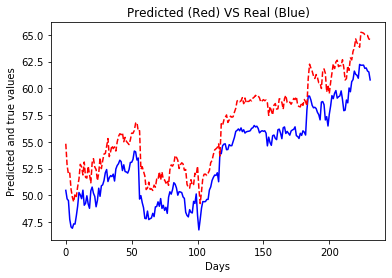

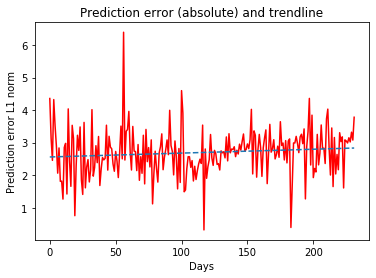

In [57]:
# 주가 예측

symbol = "MSFT"
feat_dimension = 20
train_size = 252
test_size = 252-feat_dimension

# 텐서플로 설정
learning_rate = 0.5
optimizer = tf.train.AdamOptimizer
n_epochs = 20000

# 주가를 가져와 훈련 데이터와 테스트 데이터를 분할
stock_values = fetch_stock_price(symbol, datetime.date(2015, 1, 1), datetime.date(2016, 12, 31))
minibatch_stock_X, minibatch_stock_y = format_dataset(stock_values, feat_dimension)
train_X = minibatch_stock_X[:train_size, :].astype(np.float32)
train_y = minibatch_stock_y[:train_size].reshape((-1, 1)).astype(np.float32)
test_X = minibatch_stock_X[train_size:, :].astype(np.float32)
test_y = minibatch_stock_y[train_size:].reshape((-1, 1)).astype(np.float32)

# 플레이스홀더 정의
X_tf = tf.placeholder("float", shape = (None, feat_dimension), name = "X")
y_tf = tf.placeholder("float", shape = (None, 1), name = "y")

# 훈련 가능한 매개변수(가중치, 편향값) 초기화
# truncated_normal : 절단 정규 분포
weights = tf.Variable(tf.truncated_normal([feat_dimension, 1], mean = 0.0, stddev = 1.0), name = 'weights')
biases = tf.Variable(tf.zeros([1, 1]), name = 'bias')

y_pred = regression_ANN(X_tf, weights, biases)
cost = tf.reduce_mean(tf.square(y_tf - y_pred))
train_op = optimizer(learning_rate).minimize(cost)

with tf.Session() as sess :
    # 변수 초기화
    sess.run(tf.global_variables_initializer())
    
    # 한 세대마다 전체 훈련 데이터셋이 텐서플로 그래프에 공급된다
    for i in range(n_epochs) :
        train_cost, _ = sess.run([cost, train_op], feed_dict = {X_tf : train_X, y_tf : train_y})
        print("Training iteration", i, "MSE", train_cost)
        
    # 훈련시킨 다음
    # 테스트 데이터셋에 대한 성능 확인
    test_cost, y_pr = sess.run([cost, y_pred], feed_dict= {X_tf : test_X, y_tf : test_y})
    print("Test dataset : ", test_cost)
    
    # y_train = sess.run(y_pred, feed_dict = {X_tf: train_X, y_tf : train_y})
    
    # 결과 평가
    evaluate_ts(test_X, test_y, y_pr)

In [65]:
len(stock_values[:train_size])

252

In [68]:
train_size

252

In [75]:
len(stock_values[:test_size])

232

In [78]:
# plt.plot(range(len(stock_values[:test_size])), stock_values[:test_size], 'b') # 실제값
# plt.plot(range(len(stock_values[:test_size:])), y_pr, 'r--') # 예측값
# plt.xlabel("Days")
# plt.ylabel("Predicted and true values")
# plt.title("Predicted (Red) VS Real (Blue)")
# plt.show()